### 2. Setup

In this section I import all the necessary libraries and read the data from the dataset uploaded. I downloaded every csv files containing games from every pro leagues (LCS, LEC, LCK, EM...) from 2014 to 19/03/2025. 
For now, the model is training on theses files and I aim to update the data automatically every day. So the model will be able to retrain and refine his predictions based on the last trend.
The data comes from [oracleselixir.com](https://oracleselixir.com/) which compile data from several different sources, including Match History pages, lolesports.com, lpl.QQ.com, Leaguepedia, the Riot Games solo queue APIs, and more.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,LabelEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from scipy.stats import pointbiserialr
import pandas as pd
import lightgbm as lgb
import numpy as np
import glob
import json
import itertools
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_tree
from joblib import cpu_count
import os
import gdown
import sys
import requests
from datetime import datetime, timedelta

print("Setup Complete")

Setup Complete


## Connection with database

In [ ]:
from supabase import create_client, Client

url: str  = os.getenv("SUPABASE_URL")
print ("supabase url: ", url)
service_role_key: str = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(url, service_role_key)

supabase url:  None


SupabaseException: supabase_url is required

# 3. Gathering Data 

In [5]:
working_folder = "/kaggle/working/"
url_share_raw_2025 = "https://drive.google.com/file/d/1v6LRphp2kYciU4SXp0PCjEMuev1bDejc/view?usp=sharing"
url_dowload_raw_2025 = "https://drive.google.com/uc?id=1v6LRphp2kYciU4SXp0PCjEMuev1bDejc"
output = "new_raw_data_actual_season.csv"

# Load every file of the data set
if (os.path.exists(f"{working_folder}raw_data_all_years.csv")):
    df_raw_all_years = pd.read_csv("raw_data_all_years.csv")
else:  
    folder_path = "/kaggle/input/lol-esports-match-2014-19-03-2025/"
    file_paths = glob.glob(folder_path + "*.csv")
    df_raw_all_years = pd.concat([pd.read_csv(file, index_col="gameid", low_memory=False, parse_dates=True) for file in file_paths])
    df_raw_all_years.to_csv("raw_data_all_years.csv")
    print("df_raw_all_years", df_raw_all_years.shape)
    display(df_raw_all_years.head())


### Loading File data
gdown.download(url_dowload_raw_2025, output, quiet=False)
X_2025 = pd.read_csv("/kaggle/input/lol-esports-match-2014-19-03-2025/2025_LoL_esports_match_data_from_OraclesElixir.csv", index_col="gameid",low_memory=False, parse_dates=True)
df_today_raw_season = pd.read_csv(f"{working_folder}{output}", index_col="gameid", parse_dates=True, low_memory=False) # Raw data of this season downloaded today

limited_paths = ["/kaggle/input/lol-esports-match-2014-19-03-2025/2020_LoL_esports_match_data_from_OraclesElixir.csv",
                         "/kaggle/input/lol-esports-match-2014-19-03-2025/2021_LoL_esports_match_data_from_OraclesElixir.csv",
                         "/kaggle/input/lol-esports-match-2014-19-03-2025/2022_LoL_esports_match_data_from_OraclesElixir.csv",
                         "/kaggle/input/lol-esports-match-2014-19-03-2025/2023_LoL_esports_match_data_from_OraclesElixir.csv",
    "/kaggle/input/lol-esports-match-2014-19-03-2025/2024_LoL_esports_match_data_from_OraclesElixir.csv"
]

df_raw_previous_season = pd.concat([pd.read_csv(file, index_col="gameid",  low_memory=False, parse_dates=True) for file in limited_paths])
X_valid = pd.read_csv(limited_paths[-1], index_col="gameid", low_memory=False, parse_dates=True)


print("df_raw_previous_season Shape", df_raw_previous_season.shape)
display(df_raw_previous_season)

print("X_valid Shape", X_valid.shape)
display(X_valid)

print("X_2025 Shape", X_2025.shape)
display(X_2025.head())

#print(X_2025.describe())



ValueError: No objects to concatenate

## Loading local historic files and checking for new data

In [13]:
df_saved_raw_season = pd.read_csv(f"{working_folder}raw_data_actual_season.csv") # Raw data of this season downloaded yesterday
match_logs = pd.read_csv(f"{working_folder}match_logs.csv") # Key file storing prediction and true results
X_saved_train = pd.read_csv(f"{working_folder}X_train.csv") # Training dataset of yesterday
y_saved_train = X_saved_train["result"]

if (df_saved_raw_season.shape[0]== df_today_raw_season.shape[0]):
    sys.exit("No new data detected today. Exit.")
print(f"New data detected ! {df_today_raw_season.shape[0] - df_saved_raw_season.shape[0]} new rows")
print(f"Numbers of rows yesterday : {df_saved_raw_season.shape[0]}")
print(f"Numbers of rows today {pd.Timestamp.today().strftime('%Y-%m-%d')} : {df_today_raw_season.shape[0]}")
display(X_saved_train)

New data detected ! 54084 new rows
Numbers of rows yesterday : 0
Numbers of rows today 2025-05-11 : 54084


,bo_id,year,playoffs,patch,gamelengthA,killsA,deathsA,assistsA,doublekillsA,triplekillsA,...,wpm_diff,wardskilled_diff,wcpm_diff,controlwardsbought_diff,totalgold_diff,earnedgold_diff,earned gpm_diff,goldspent_diff,monsterkills_diff,win_rate_diff
0,0,2020.0,0.0,9.24,2039.2500,14.7500,10.2500,29.5000,2.2500,0.2500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2020.0,0.0,9.24,1651.3333,18.0000,3.6667,43.3333,3.3333,1.6667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,2020.0,0.0,9.24,1762.3333,21.6667,5.3333,48.6667,4.0000,0.6667,...,-0.532600,-34.666700,-0.685400,-19.166700,-8791.250000,-4834.666700,116.079900,-8976.916700,-56.000000,0.000000
3,3,2020.0,0.0,10.01,2132.3333,19.0000,19.6667,40.0000,2.3333,0.6667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,2020.0,0.0,10.01,1972.0000,10.3333,15.0000,23.0000,0.6667,0.3333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31630,31630,2025.0,0.0,14.23,1858.0000,13.0000,15.0000,36.0000,0.0000,0.0000,...,-0.316586,-2.925763,-0.069436,-5.298473,-2255.563247,-1614.297071,-31.575781,-2866.558974,-50.750915,-0.102564
31631,31631,2025.0,0.0,14.23,1796.0000,13.0000,27.0000,29.0000,2.0000,0.0000,...,-0.104883,-3.475861,-0.084107,-5.747415,-578.409554,46.553951,26.271459,-1556.869111,-28.951582,0.021552
31632,31632,2025.0,0.0,14.23,2092.3333,16.3333,18.6667,41.6667,2.6667,0.3333,...,0.058665,1.398006,-0.013325,2.798066,3420.261217,2762.900233,56.523436,2381.232299,22.276772,0.251178
31633,31633,2025.0,0.0,14.23,1877.0000,20.3333,12.6667,49.6667,3.6667,0.3333,...,0.028953,-3.663431,-0.143587,2.450534,-338.726536,-604.101316,-37.484238,248.035330,7.220853,-0.110810


In [14]:
# Some constants
cols_to_be_unique = ["patch","year","playoffs","split","game","date","league"]

# 4. Data Preprocessing
In this section, we transform raw data into a format suitable for model training.

### **1. Filtering Relevant Data**

Certain columns are removed as they are not relevant to our analysis (e.g., `url`, `participantId`...).

Additionally, we exclude incomplete games, as analyzing partially played matches would introduce bias into the results.

### **2. Aggregating Data**

The raw dataset contains individual player performances for each match. However, to simplify the model, we aggregate the data at the team level and do not consider individual performance.

### **3. Preventing Data Leakage**

Initially, each row in the dataset contains both the match result and the in-game statistics. Training a model on this information would cause **data leakage**, as we wouldn’t have access to match statistics before the game occurs.

To prevent this, we replace in-game statistics with each team's historical performance before the match. After each game, these statistics are updated accordingly.

### **Example:**

- On **April 20, 2014**, FNC plays against SKT T1 with a current win rate of **75%**. The model trains on this data.
- On **April 21, 2014**, FNC faces SSG. Their win rate is recalculated based on the previous match result, likely increasing slightly 😄. The model is then trained with the updated win rate.

This approach ensures that predictions rely **only on information available before each match**, improving the model’s generalization and reliability.

In [15]:
#1. Filtering incomplete games and useless columns for the model winner series
def winner_series_filtering(df):
    # Drop games not complete
    new_df = df[df["datacompleteness"] == "complete"]

    # Define columns to be removed and drop them (useless columns)
    useless_columns = (
        ["participantid", "side", "position", "teamid", "teamkills", "teamdeaths","url"] +
        [f"ban{b}" for b in range(1, 6)] +
        [f"pick{p}" for p in range(1, 6)]
    )
    
    new_df = new_df.drop(columns=useless_columns)
        # Colonnes à garder même si elles ont une seule valeur
    exceptions = set(cols_to_be_unique)
    
    # Colonnes à supprimer : elles ont une seule valeur et ne sont pas dans exceptions
    cols_to_drop = [col for col in new_df.columns if new_df[col].nunique() <= 1 and col not in exceptions]
    
    # On les supprime
    new_df = new_df.drop(columns=cols_to_drop)
    
    return new_df

#X_2025 = winner_series_filtering(X_2025)

#Select only game on EM to try
X_2025_EM = X_2025[X_2025["league"] == "EM"]
X_2025_EM = winner_series_filtering(X_2025)

# List of feature for my AI Intuition
features = ['Team', 'TeamElo','WinRateLast10Game','WinStreaks','LoseStreaks','HeadToHead','AverageKills','AverageDeaths','AverageAssists','AverageDoubleKills','AverageTripleKills','AverageQuadraKills','AveragePentakills','AverageKpM','Patch','WinRateCurrentPatchA']
features_engineered = ['TeamElo','WinRateLast10Game','WinStreaks','LoseStreaks','HeadToHead','Patch','WinRateCurrentPatchA']

#print(X_2025_EM.columns.tolist())


In [16]:
### 2. Select only the rows with the Team score and delete empty columns
def select_teams_rows(df):
    
    new_df = df[df["playername"].isnull()] # Select only team's row with aggregate data
    print("Shape before selecting only teams rows", new_df.shape)
    series_empty = new_df.isna().sum()
    columns_with_all_rows_empty = series_empty[series_empty == new_df.shape[0]].index.tolist()
    columns_to_drop = ["firstbloodkill","firstbloodassist","firstbloodvictim","champion"]
    new_df = new_df.drop(columns=columns_with_all_rows_empty+ columns_to_drop, axis=1) # Drop full columns empty
    new_df = new_df[(new_df.game.isnull() == False) & (new_df.teamname.isnull() == False)] 
    print("Shape after selecting only teams rows", new_df.shape)
    series_empty = new_df.isna().sum()
    
    #print(set(series_empty[series_empty != 0].index.tolist())-set(columns_mean)-set(columns_to_let_xgb)-set(columns_to_set_0))
    
    #print("\n".join(series_empty[series_empty != 0].index.astype(str)))
    #print(len(series_empty[series_empty != 0].index))
    #print("\n".join(f"{index}: {value}" for index, value in series_empty[series_empty != 0].items()))

    #print(series_empty[series_empty != 0])
    #new_df = new_df.dropna(axis=1)
    return new_df
    
#X_2025_EM_TEAM_RESULTS = select_teams_rows(X_2025_EM)
X_2025_EM = X_2025[X_2025["league"] == "EM"]
X_2025_EM = select_teams_rows(X_2025_EM)
display(X_2025_EM)
# display(test_limited[test_limited.champion.isnull() == False].iloc[0]["champion"])
# display(X_2025_EM_TEAM_RESULTS.head())
# print(X_2025_EM_TEAM_RESULTS.shape)
#X_2025_EM_TEAM_RESULTS.to_csv('X_2025_EM_TEAM_RESULTS.csv')
# drop year, label league + wr_league, keep split + wr_split, keep playoffs + wr_playoffs, keep patch + wr_patch

Shape before selecting only teams rows (90, 160)
Shape after selecting only teams rows (90, 147)


,datacompleteness,league,year,split,playoffs,date,game,patch,participantid,side,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
gameid,,,,,,,,,,,,,,,,,,,,,
LOLTMNT04_102216,complete,EM,2025,Winter,0,2025-03-17 16:01:35,1,15.05,100,Blue,...,908.0,-5830.0,-7321.0,-102.0,6.0,20.0,13.0,13.0,31.0,6.0
LOLTMNT04_102216,complete,EM,2025,Winter,0,2025-03-17 16:01:35,1,15.05,200,Red,...,806.0,5830.0,7321.0,102.0,13.0,31.0,6.0,6.0,20.0,13.0
LOLTMNT04_103229,complete,EM,2025,Winter,0,2025-03-17 16:01:54,1,15.05,100,Blue,...,780.0,5316.0,10489.0,80.0,16.0,48.0,8.0,8.0,12.0,16.0
LOLTMNT04_103229,complete,EM,2025,Winter,0,2025-03-17 16:01:54,1,15.05,200,Red,...,860.0,-5316.0,-10489.0,-80.0,8.0,12.0,16.0,16.0,48.0,8.0
LOLTMNT04_102217,complete,EM,2025,Winter,0,2025-03-17 16:02:14,1,15.05,100,Blue,...,929.0,-591.0,-1455.0,11.0,3.0,5.0,7.0,7.0,14.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOLTMNT04_103321,complete,EM,2025,Winter,0,2025-03-19 18:48:29,2,15.05,200,Red,...,848.0,-11903.0,-14353.0,-58.0,5.0,9.0,20.0,20.0,48.0,5.0
LOLTMNT04_102278,complete,EM,2025,Winter,0,2025-03-19 19:32:32,3,15.05,100,Blue,...,893.0,-1955.0,1228.0,-50.0,9.0,21.0,7.0,7.0,19.0,9.0
LOLTMNT04_102278,complete,EM,2025,Winter,0,2025-03-19 19:32:32,3,15.05,200,Red,...,843.0,1955.0,-1228.0,50.0,7.0,19.0,9.0,9.0,21.0,7.0


From this point, we preprocess furthermore the data and aggregate from the team's row every BO.
We will develop two different models:

1. **winner_series** – This model predicts the outcome of a series (Best of X) without any prior knowledge except for the team names, the type of series (BO format), their historical statistics and of caurse the features we created.
2. **score_series** – Based on the prediction from *winner_series*, this model forecasts the exact score of the series (e.g., 2-1).

### Aggregating BO
From here all the rows belonging to the same BO are compiled into 1 row.
We drop the exact result (eg, 2-1) and take only the result of the series

In [17]:
#3. Preventing Data Leakage, creating a new data with updated stats and feature engineered over time. 


def aggregate_bo(df, include_objects_columns=False):
    """
    This function processes the given dataframe `df`, which contains match data, 
    by cleaning, grouping, and calculating statistics for each Best-of (Bo) series 
    and each team within the series.
    """

    #assert not df.isnull().values.any(), "Dataset contains missing values, cannot aggregate BO"
    
    # Step 1: Sort the data by date and team name to organize the games
    team_games = df.sort_values(by=["date", "gameid","teamname"]).copy()
    counts_index = team_games.index.value_counts()
    
    #team_games = team_games[team_games.index.isin(counts_index[counts_index > 1].index)]
    #display(team_games[team_games.index== "ESPORTSTMNT02_2342149"])
    #display(team_games[team_games["date"]=="2025-01-23 16:22:48"])
    
    # Step 2: Separate the team data for left and right teams based on row order
    teams_stats_left = team_games.iloc[::2]  # Select rows for team A
    teams_stats_right = team_games.iloc[1::2]  # Select rows for team B
    #print("List of columns before creating A and B",team_games.columns.tolist())
    # Step 3: Join the stats of the two teams (team A and team B) into one DataFrame
    teams_group = teams_stats_left.join(teams_stats_right, lsuffix="A", rsuffix="B")
    # Make a unique column for same value between match 
    cols_b_drop = [col + 'B' for col in cols_to_be_unique]
    teams_group = teams_group.drop(columns=cols_b_drop, axis=1) 
    teams_group.rename(columns={col+"A":col for col in cols_to_be_unique }, inplace=True) 
    
    teams_group = teams_group[(teams_group["teamnameA"]!="unknown team") & (teams_group["teamnameB"] !="unknown team")]
    teams_group = teams_group.dropna(subset=["teamnameA","teamnameB"],axis=0)
    # Step 4: Initialize the dictionary to store unique Bo IDs and track the count
    dict_bo = {"id": 0}
    # Step 5: Define a function to identify the Bo series ID (`bo_id`) for each match
    def identify_bo_id(row):
        # Define a unique key for each Bo series based on the team names
        if (isinstance(row.teamnameA, float) | isinstance(row.teamnameB, float)):
            print("teamA",row.teamnameA)
            print("teamB", row.teamnameB)
            print("game",row)
            
        key = row.teamnameA + "_" + row.teamnameB if row.teamnameA < row.teamnameB else row.teamnameB + "_" + row.teamnameA
        
        # Check if this is the first game of a Bo series
        if row["game"] == 1:  # If this is the first game of the Bo series
            # Assign a new Bo ID for this series and increment the counter
            dict_bo[key] = dict_bo["id"] #row.name
            dict_bo["id"] += 1
            return dict_bo[key]
        else:
            # If the Bo series already exists, return the existing Bo ID
            return dict_bo.get(key)  # Return the Bo ID, if already exists
    
    # Step 6: Apply the `identify_bo_id` function to each row and add the Bo ID to the DataFrame
    teams_group["bo_id"] = teams_group.apply(identify_bo_id, axis=1)
    # Step 7: Drop rows where `bo_id` is missing (if any) and convert `bo_id` to integer type
    #teams_group.dropna(axis=0, inplace=True)
    teams_group = teams_group[teams_group["bo_id"].isnull() == False]
    teams_group["bo_id"] = teams_group["bo_id"].astype(int)
    # Step 8: Calculate the Bo type (Bo1, Bo3, Bo5) based on the number of games in the series
    def get_type_bo(df):
        nb_games = df.game.count()
        if nb_games == 1:
            return 1  # Bo1
        elif nb_games == 2:
            return 3  # Bo3
        elif nb_games == 3:
            # If Bo3, check if there was a winner by 3 games in a row
            if df.resultA.mean() == 1 or df.resultB.mean() == 1:
                return 5  # Bo5 won by 3 victories in a row
            else:
                return 3  # Bo3 with 1 defeat
        else:
            return 5  # Bo5 (4 or 5 games)

    # Step 9: Calculate the mean statistics for each group (Bo series) while keeping 4 decimal precision
    nums_cols = teams_group.select_dtypes(include=["number"]).columns  # Get all numeric columns
    X = teams_group.groupby("bo_id")[nums_cols].mean().round(4)
    
    # Add object columns by taking the first value for each group
    object_cols = teams_group.select_dtypes(include=["object"]).columns.tolist()
    if ("bo_id" in object_cols):
        object_cols.remove("bo_id")
    # Use .transform to get the first value for each group for object columns
    if (not include_objects_columns):
        object_cols = ["teamnameA","teamnameB"]

    # Step 10: Add `teamnameA`, `teamnameB`, and `bo_type` for each group (Bo series)
    X[["bo_type"]+object_cols] = teams_group.groupby("bo_id").apply(
        lambda df: pd.Series({
            "bo_type": get_type_bo(df),
            **{col: df[col].iloc[0] for col in object_cols}
        }),
        include_groups=False
    ).reset_index(drop=True)  # Reset the index to align the results correctly
    
    # Step 11: Clean up the resulting DataFrame by dropping unnecessary columns
    X.drop(columns=["game"], inplace=True)

    # Return the final DataFrame with team statistics by Bo series
    return X


X_aggregated = aggregate_bo(X_2025_EM, True)
display(X_aggregated)

#create_team_stats_2(X_2025_EM_TEAM_RESULTS).to_csv("X_2025_EM_BO_RESULTS.csv")


,year,playoffs,patch,participantidA,gamelengthA,resultA,killsA,deathsA,assistsA,teamkillsA,...,ban1B,ban2B,ban3B,ban4B,ban5B,pick1B,pick2B,pick3B,pick4B,pick5B
bo_id,,,,,,,,,,,,,,,,,,,,,
0,2025.0,0.0,15.05,200.0000,1724.5000,1.0000,20.0000,9.0000,42.5000,20.0000,...,Nocturne,Jayce,Ezreal,Viktor,Sylas,Varus,Xin Zhao,Orianna,Rell,Malphite
1,2025.0,0.0,15.05,150.0000,1714.5000,1.0000,33.0000,10.0000,70.0000,33.0000,...,Rumble,Vi,Varus,Taliyah,Kai'Sa,Skarner,Ezreal,Ambessa,Azir,Braum
2,2025.0,0.0,15.05,150.0000,2634.5000,1.0000,21.5000,15.5000,44.5000,21.5000,...,Sion,Kalista,Janna,Karma,Leona,Maokai,Yone,Kai'Sa,Jayce,Neeko
3,2025.0,0.0,15.05,133.3333,1744.3333,0.6667,20.0000,11.3333,41.3333,20.0000,...,Ezreal,Kalista,Miss Fortune,Akali,Viktor,Rumble,Varus,Yone,Viego,Nautilus
4,2025.0,0.0,15.05,150.0000,1802.0000,0.0000,10.0000,25.5000,21.0000,10.0000,...,Caitlyn,Ivern,Jayce,Zyra,Sylas,Maokai,Corki,Renekton,Rakan,Taliyah
5,2025.0,0.0,15.05,150.0000,1678.0000,0.0000,6.0000,22.0000,12.5000,6.0000,...,Zyra,Varus,Vi,Ezreal,Corki,Rumble,Sejuani,Yone,Xayah,Rakan
6,2025.0,0.0,15.05,133.3333,2055.3333,0.3333,13.3333,15.6667,31.6667,13.3333,...,Azir,Bel'Veth,Viego,Leona,Braum,Maokai,Miss Fortune,Rell,Gwen,Yone
7,2025.0,0.0,15.05,100.0000,1515.5000,1.0000,26.5000,8.0000,57.0000,26.5000,...,Zyra,Maokai,Renekton,Orianna,Viktor,Ezreal,Xin Zhao,Leona,Aurora,Garen
8,2025.0,0.0,15.05,133.3333,2572.0000,0.3333,19.0000,27.3333,39.6667,19.0000,...,Caitlyn,Jayce,Ivern,Orianna,Viktor,Varus,Pantheon,Azir,Gnar,Renata Glasc


## Creating features

In [18]:
def winner_series_create_features(df, include_objects_columns=False):
    BASE_ELO = 1500  # Starting ELO for new teams
    K_FACTOR = 45  # ELO adjustment speed
    WINDOW_SIZE = 1  # Number of past matches to compute rolling averages
    WINDOW_RECENT = 5

    new_df = winner_series_filtering(df)
    display(new_df)
    new_df = select_teams_rows(new_df)
    # Based on the code below commented, nums colomns that we want to make stats from the dataframe with team's row
    nums_cols_avg_stats_fixed = ['gamelength', 'kills', 'deaths', 'assists', 'doublekills', 'triplekills', 'quadrakills', 'pentakills', 'firstblood', 'team kpm', 'ckpm', 'firstdragon', 'dragons', 'opp_dragons', 'elementaldrakes', 'opp_elementaldrakes', 'infernals', 'mountains', 'clouds', 'oceans', 'chemtechs', 'hextechs', 'elders', 'opp_elders', 'firstherald', 'heralds', 'opp_heralds', 'void_grubs', 'opp_void_grubs', 'firstbaron', 'barons', 'opp_barons', 'firsttower', 'towers', 'opp_towers', 'firstmidtower', 'firsttothreetowers', 'turretplates', 'opp_turretplates', 'inhibitors', 'opp_inhibitors', 'damagetochampions', 'dpm', 'damagetakenperminute', 'damagemitigatedperminute', 'wardsplaced', 'wpm', 'wardskilled', 'wcpm', 'controlwardsbought', 'visionscore', 'vspm', 'totalgold', 'earnedgold', 'earned gpm', 'goldspent', 'gspd', 'gpr', 'minionkills', 'monsterkills', 'cspm', 'goldat10', 'xpat10', 'csat10', 'opp_goldat10', 'opp_xpat10', 'opp_csat10', 'golddiffat10', 'xpdiffat10', 'csdiffat10', 'killsat10', 'assistsat10', 'deathsat10', 'opp_killsat10', 'opp_assistsat10', 'opp_deathsat10', 'goldat15', 'xpat15', 'csat15', 'opp_goldat15', 'opp_xpat15', 'opp_csat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15', 'killsat15', 'assistsat15', 'deathsat15', 'opp_killsat15', 'opp_assistsat15', 'opp_deathsat15', 'goldat20', 'xpat20', 'csat20', 'opp_goldat20', 'opp_xpat20', 'opp_csat20', 'golddiffat20', 'xpdiffat20', 'csdiffat20', 'killsat20', 'assistsat20', 'deathsat20', 'opp_killsat20', 'opp_assistsat20', 'opp_deathsat20', 'goldat25', 'xpat25', 'csat25', 'opp_goldat25', 'opp_xpat25', 'opp_csat25', 'golddiffat25', 'xpdiffat25', 'csdiffat25', 'killsat25', 'assistsat25', 'deathsat25', 'opp_killsat25', 'opp_assistsat25', 'opp_deathsat25']
    nums_cols_avg_stats = new_df.select_dtypes(include="number").columns.tolist()
    cols_to_remove = ["game","participantid","teamkills","teamdeaths","result"] + cols_to_be_unique
    nums_cols_avg_stats = [x for x in nums_cols_avg_stats if x not in cols_to_remove]
    league_avg = {stats: new_df[stats].mean() for stats in nums_cols_avg_stats} # Mean stats for the first game of team's
    print("columns after select teams",new_df.columns.tolist())
    display(new_df)
    dict_stats = {team: {col:[] for col in nums_cols_avg_stats } | {"h2h":[], "result":[], "bo_1":[],"bo_3":[],"bo_5":[], "win_streak":[], "elo":[BASE_ELO]} for team in set(new_df.teamname) }

    # Initialize the first team with the base ELO 
    #1. S'assurer que la date est bien en format datetime
    new_df['dateparsed'] = pd.to_datetime(new_df['date'])
    
    # 2. Calculer la limite de 6 mois depuis la date min
    date_limite = new_df['dateparsed'].min() + pd.DateOffset(months=6)
    
    # 3. Identifier les équipes présentes pendant cette période
    teams_initial_elo = new_df[new_df['dateparsed'] <= date_limite]['teamname'].unique()
    
    # 4. Initialiser leur ELO à 1500 dans dict_stats
    for team in teams_initial_elo:
        dict_stats[team]['elo'].append(BASE_ELO)
    
    new_df = aggregate_bo(new_df, True)    
    new_df["result"] = new_df.resultB.map(lambda row: 1 if row >0.5 else 0) # 0 if TeamA win , 1 if TeamB win
    new_df = new_df.drop(columns=["resultA","resultB"])

    # Constants
    
    
    league_avg["elo"] = BASE_ELO
    
    
    #Function to calculate ELO updates
    def calculate_elo(elo_A, elo_B, result_B, K):
        expected_A = 1 / (1 + 10 ** ((elo_B - elo_A) / 400))
        expected_B = 1 - expected_A
        new_elo_A = elo_A + K * ((1-result_B) - expected_A)
        new_elo_B = elo_B + K * (result_B - expected_B)
        return new_elo_A, new_elo_B
    
    # Initialize empty DataFrame
    # team_stats_df = pd.DataFrame(columns=["team","elo"] + nums_cols_avg_stats + ["result"])
    
    # # Function to get rolling averages safely
    # def get_team_stat(team, col):
    #     team_data = team_stats_df[team_stats_df["team"] == team]
    #     if len(team_data) >= WINDOW_SIZE:
    #         return team_data[col].rolling(WINDOW_SIZE).mean().iloc[-1]
    #     return league_avg[col]  # Default to league average if not enough data
    
    # Process each match
    # Buffer pour stocker les valeurs calculées
    data_buffer = []
    
    for i, row in new_df.iterrows():
        team_A, team_B = row["teamnameA"], row["teamnameB"]
        row_result = {}
    
        # ELO pré-match
        # if (len(dict_stats[team_A]["elo"]) == 0):
        #     elos = [stats["elo"] for stats in dict_stats.values() if isinstance(stats, dict)]
        #     mean_elo = np.percentile([e for sublist in elos for e in sublist], 75)
        #     dict_stats[team_A]["elo"].append(mean_elo)
        # if (len(dict_stats[team_B]["elo"]) == 0):
        #     elos = [stats["elo"] for stats in dict_stats.values() if isinstance(stats, dict)]
        #     mean_elo = np.percentile([e for sublist in elos for e in sublist], 75)
        #     dict_stats[team_B]["elo"].append(mean_elo)
        pre_game_elo_A = dict_stats[team_A]["elo"][-1]
        pre_game_elo_B = dict_stats[team_B]["elo"][-1]
        row_result["elo_diff"] = pre_game_elo_A - pre_game_elo_B
    
        # H2H win rate
        h2h_key = team_A + team_B
        h2h_win_rate_AvsB = np.mean(dict_stats[h2h_key]) if dict_stats.get(h2h_key) else 0.5
        row_result["h2h_win_rate_AvsB"] = h2h_win_rate_AvsB
        dict_stats[team_A]["h2h"].append(h2h_win_rate_AvsB)
        dict_stats[team_B]["h2h"].append(1 - h2h_win_rate_AvsB)

        # Nb games diff
        row_result["nb_games_diff"] = len(dict_stats[team_A]["result"]) - len(dict_stats[team_B]["result"])

        # new games
        row_result["new_games"] = (len(dict_stats[team_A]["result"]) <= 5 | len(dict_stats[team_B]["result"]) <=5)

        # Win streaks
        def compute_win_streak(results):
            win_streak = 0
            idx = len(results) - 1
            while idx >= 0 and results[idx] == 1:
                win_streak += 1
                idx -= 1
            return win_streak
        
        # Utilisation
        win_streak_A = compute_win_streak(dict_stats[team_A]["result"])
        win_streak_B = compute_win_streak(dict_stats[team_B]["result"])
        dict_stats[team_A]["win_streak"].append(win_streak_A)
        dict_stats[team_B]["win_streak"].append(win_streak_B)
        # row_result["win_streakA"] = win_streak_A
        # row_result["win_streakB"] = win_streak_B
        row_result["win_streak_diff"]  = win_streak_A - win_streak_B
        
        # Win rates globaux et par BO
        team_A_res, team_B_res = dict_stats[team_A]["result"], dict_stats[team_B]["result"]
        row_result["team_A_win_rate"] = np.mean(team_A_res) if len(team_A_res) >= WINDOW_SIZE else 0.5
        row_result["team_B_win_rate"] = np.mean(team_B_res) if len(team_B_res) >= WINDOW_SIZE else 0.5

        # Win rate BO Diff
        win_rate_bo_A = np.mean(dict_stats[team_A][f"bo_{row['bo_type']}"]) if len(dict_stats[team_A][f"bo_{row['bo_type']}"]) >= WINDOW_SIZE else row_result["team_A_win_rate"]
        win_rate_bo_B = np.mean(dict_stats[team_B][f"bo_{row['bo_type']}"]) if len(dict_stats[team_B][f"bo_{row['bo_type']}"]) >= WINDOW_SIZE else row_result["team_B_win_rate"]
        row_result["win_rate_bo_diff"] = win_rate_bo_A - win_rate_bo_B
        for window in [3, 5, 10]:
            win_rate_A = np.mean(team_A_res[-window:]) if len(team_A_res) >= window else row_result["team_A_win_rate"]
            win_rate_B = np.mean(team_B_res[-window:]) if len(team_B_res) >= window else row_result["team_B_win_rate"]
            row_result[f"win_rate_last_{window}_diff"] = win_rate_A - win_rate_B
    
        # Moyennes de stats
        for col in nums_cols_avg_stats:
            stat_A = np.mean(dict_stats[team_A][col]) if len(dict_stats[team_A][col]) >= WINDOW_SIZE else league_avg[col]
            stat_B = np.mean(dict_stats[team_B][col]) if len(dict_stats[team_B][col]) >= WINDOW_SIZE else league_avg[col]
            row_result[col + "_diff"] = stat_A - stat_B
            dict_stats[team_A][col].append(row[col + "A"])
            dict_stats[team_B][col].append(row[col + "B"])
    
        # Append dans le buffer
        data_buffer.append(row_result)
    
        # Mise à jour ELO & résultats
        new_elo_A, new_elo_B = calculate_elo(pre_game_elo_A, pre_game_elo_B, row["result"], K_FACTOR)
        dict_stats[team_A]["elo"].append(new_elo_A)
        dict_stats[team_B]["elo"].append(new_elo_B)
    
        for key in ["result", f"bo_{row['bo_type']}"]:
            dict_stats[team_A][key].append(1 - row["result"])
            dict_stats[team_B][key].append(row["result"])
    
        dict_stats.setdefault(h2h_key, []).append(1 - row["result"])
    
    # Fusion des colonnes calculées avec new_df
    stats_df = pd.DataFrame(data_buffer)
    new_df.reset_index(drop=True, inplace=True)
    new_df = pd.concat([new_df, stats_df], axis=1)
    new_df.index.name = "bo_id"
    
    # Calcul win_rate_diff final
    new_df["win_rate_diff"] = new_df["team_A_win_rate"] - new_df["team_B_win_rate"]
    
    return new_df, dict_stats

#X_limited_EM = X_limited[(X_limited["league"]=="LFL")  & (X_limited.split == "Spring")] # & (X_limited.date > "2024-01-17 ") & (X_limited.date < "2024-03-14 ")
#X_intuition, dict_stats = winner_series_create_features(df_raw_previous_season, True)
# X_intuition_clean = X_intuition.dropna(axis=1)
#display(X_intuition)
# Saving to csv
# X_intuition.to_csv("X_intuition_2023-2025.csv")
# X_intuition_clean.to_csv("X_intuition_2023-2025_clean.csv")
# with open('dict_stats.json', 'w') as f:
#     json.dump(dict_stats, f)
# print("X_intuition dirty shape:",X_intuition.shape)
# print("X_intuition clean shape:",X_intuition_clean.shape)

In [19]:

# # ✅ 1. Assert no missing values (or handle them)
# #assert not X_intuition.isnull().values.any(), "Dataset contains missing values!"

# # # ✅ 3. Feature Engineering Function (Avoiding Data Leakage)
# # def create_team_stats(df):
# #     """
# #     Compute team-level statistics based ONLY on past matches (not future).
# #     """
# #     df_sorted = df.sort_values("match_date")  # Ensure chronological order
# #     team_stats = df_sorted.groupby("team_id").agg({
# #         "win": "mean",   # Team win rate
# #         "gold_diff": "mean",  # Average gold diff
# #         "kills": "mean",  # Average kills
# #         "deaths": "mean",  # Average deaths
# #     }).reset_index()


# # # Custom transformer to apply feature engineering ONLY on training data
# # feature_engineering_transformer = FunctionTransformer(create_team_stats, validate=False)

# # ✅ 4. Categorical Encoding (Label Encoding for teams & champions)

# def only_diff(df):
#     cols_df = df.columns.tolist()
#     cols_A = [col for col in cols_df if col[-1]=="A"]
#     cols_B = [col for col in cols_df if (col[-1]=="B") & (col !="h2h_win_rate_AvsB")]
#     assert len(cols_A) == len(cols_B), "Taille de colonne A différente de colonne B"
#     df = df.drop(columns=(cols_A + cols_B))
#     return df


# # ✅ 2. Drop unnecessary columns
# columns_to_drop = ["teamnameA","teamnameB","league","date",'playoffs', 'patch']  # Example: Remove match ID and timestamp
# # Columns with low MI & Correlation
# col_low_MI = [] #wpm_diff better for LGB
# # ✅ 5. Define Features and Target (Above at preprocessor)
# # ✅ Define Features and Target
# X = X_intuition_clean.drop(columns=(["result"] +columns_to_drop+ col_low_MI)) # Features
# X = only_diff(X)
# y = X_intuition["result"]  # Target: 0 (Team A wins), 1 (Team A loses)

# nums_cols = X.select_dtypes(include="number").columns.tolist()
# columns_to_set_0 = ["quadrakills","pentakills","dragons","opp_dragons","elementaldrakes","opp_elementaldrakes","infernals","mountains","clouds","oceans","chemtechs","hextechs","dragons (type unknown)","elders","opp_elders","firstherald","heralds","opp_heralds","void_grubs","opp_void_grubs","firstbaron","barons","opp_barons","firsttower","towers",'opp_towers', 'firstmidtower', 'firsttothreetowers', 'turretplates', 'opp_turretplates'] # Not here before or low impact
# cat_cols = X.select_dtypes(exclude="number").columns.tolist() 
# col_num_most_frequent = ["firstblood","firstdragon"]
# columns_mean = ['damageshare', 'earnedgoldshare', 'gspd', 'gpr', 'total cs', 'goldat10', 'xpat10', 'csat10', 'opp_goldat10', 'opp_xpat10', 'opp_csat10', 'golddiffat10', 'xpdiffat10', 'csdiffat10', 'killsat10', 'assistsat10', 'deathsat10', 'opp_killsat10', 'opp_assistsat10', 'opp_deathsat10', 'goldat15', 'xpat15', 'csat15', 'opp_goldat15', 'opp_xpat15', 'opp_csat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15', 'killsat15', 'assistsat15', 'deathsat15', 'opp_killsat15', 'opp_assistsat15', 'opp_deathsat15', 'goldat20', 'xpat20', 'csat20', 'opp_goldat20', 'opp_xpat20', 'opp_csat20', 'golddiffat20', 'xpdiffat20', 'csdiffat20', 'killsat20', 'assistsat20', 'deathsat20', 'opp_killsat20', 'opp_assistsat20', 'opp_deathsat20', 'goldat25', 'xpat25', 'csat25', 'opp_goldat25', 'opp_xpat25', 'opp_csat25', 'golddiffat25', 'xpdiffat25', 'csdiffat25', 'killsat25', 'assistsat25', 'deathsat25', 'opp_killsat25', 'opp_assistsat25', 'opp_deathsat25']
# col_most_important = ['team kpm_diff', 'gamelength_diff', 'bo_type', 'earnedgold_diff', 'wardskilled_diff', 'elo_diff', 'win_rate_diff']
# col_best_perf = ['goldspent_diff', 'win_rate_last_3_diff', 'wardsplaced_diff', 'triplekills_diff', 'assists_diff', 'monsterkills_diff', 'firstblood_diff', 'elo_diff', 'win_rate_diff', 'h2h_win_rate_AvsB', 'wardskilled_diff', 'team kpm_diff', 'ckpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 'damagetakenperminute_diff', 'gamelength_diff', 'wcpm_diff', 'bo_type']

# # Create a custom transformer for LabelEncoding both columns consistently
# def getColAandB(columns):
#     colA = [col+"A" for col in columns]
#     colB = [col+"B" for col in columns]
#     return colA + colB

# # Define the preprocessor pipeline with imputers for numeric and categorical columns
# preprocessor = Pipeline(steps=[
#     ('preprocessor', ColumnTransformer(
#         transformers=[
#             ('num_set_zero', SimpleImputer(strategy="constant", fill_value=0), list(set(getColAandB(columns_to_set_0)) & set(nums_cols))),
#             ('num_mean', SimpleImputer(strategy="mean"), list(set(nums_cols)- set(getColAandB(columns_to_set_0))- set(getColAandB(col_num_most_frequent)) -set(["patch"]))),
#             ('cat', Pipeline(steps=[
#                 ('imputer', SimpleImputer(strategy="most_frequent")),
#                 ('label', OneHotEncoder())  # Apply consistent encoding to both teamnameA and teamnameB
#             ]), cat_cols),
#             ('num_most_frequent',SimpleImputer(strategy="most_frequent"), list(set(getColAandB(col_num_most_frequent)+["patch"]) & set(nums_cols)) )
#         ]
#     ))
# ])

# preprocessor_few_col = Pipeline(steps=[
#     ("preprocessor", ColumnTransformer(
#         transformers=[
#             ("num_col_mean", SimpleImputer(strategy="mean"), col_most_important)
#         ],
#         remainder='drop'
#     ))
# ])

# preprocessor_best_perf = Pipeline(steps=[
#     ("preprocessor", ColumnTransformer(
#         transformers=[
#             ("num_col_mean", SimpleImputer(strategy="mean"), col_best_perf)
#         ],
#         remainder='drop'
#     ))
# ])

# # ✅ 6. Train/Test Split (For Cross-validation)
# X_clean = X.dropna(axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
# date_min = "2023-01-10 17:07:15"
# date_split = X_valid.iloc[0,:].date
# X_train_LFL = X_intuition_clean.drop(columns=(["result"] +columns_to_drop+col_low_MI))[(X_intuition_clean["date"] >= date_min) & (X_intuition_clean["date"] < date_split)]
# X_train_LFL = only_diff(X_train_LFL)
# y_train_LFL = X_intuition_clean[(X_intuition_clean["date"] >= date_min) & (X_intuition_clean["date"] < date_split)]["result"]
# X_valid_LFL = X_intuition_clean.drop(columns=(["result"] +columns_to_drop+col_low_MI))[(X_intuition_clean["date"] >= date_split)]
# X_valid_LFL = only_diff(X_valid_LFL)
# y_valid_LFL = X_intuition_clean[(X_intuition_clean["date"] >= date_split)]["result"]
# # ✅ 7. Pipeline: Feature Engineering + Encoding + Model
# pipeline_random = Pipeline(steps=[
#     #("feature_engineering", feature_engineering_transformer),  # Compute team stats
#     ("preprocess", preprocessor),  # Encode categorical features
#     ("model", RandomForestClassifier(n_estimators=154, random_state=42, min_samples_split=10))
# ])

# model_lgb = lgb.LGBMClassifier(n_estimators=82, learning_rate=0.05, n_jobs=4, max_bin=101, verbose=-1)

# pipeline_LGB_few_col = Pipeline([
#     ("preprocess", preprocessor_few_col),
#     ("model", model_lgb)
# ])

# pipeline_LGB_best_perf = Pipeline([
#     ("preprocess", preprocessor_few_col),
#     ("model", model_lgb)
# ])
# print(f"Nb Columns {len(X.columns.tolist())}:\n{X.columns.tolist()}")

# # pipeline_xgb = Pipeline([
# #     ("categorical_transformer", categorical_transformer),
# #     ("mode", XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=5))
# # ])
# # ✅ 8. Cross-Validation to Evaluate Model
# model_xgb = XGBClassifier(n_estimators=154, learning_rate=0.05, n_jobs=4)
# model_xgb_test = XGBClassifier(n_estimators=1500, learning_rate=0.05, early_stopping_rounds=100, n_jobs=4)
# pipeline_LGB_best_perf.fit(X_train_LFL, y_train_LFL)
# model_xgb_test.fit(X_train_LFL[['goldspent_diff', 'win_rate_last_3_diff', 'wardsplaced_diff', 'triplekills_diff', 'assists_diff', 'monsterkills_diff', 'firstblood_diff', 'elo_diff', 'win_rate_diff', 'h2h_win_rate_AvsB', 'wardskilled_diff', 'team kpm_diff', 'ckpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 'damagetakenperminute_diff', 'gamelength_diff', 'wcpm_diff', 'bo_type']], y_train_LFL, eval_set=[(X_valid_LFL[['goldspent_diff', 'win_rate_last_3_diff', 'wardsplaced_diff', 'triplekills_diff', 'assists_diff', 'monsterkills_diff', 'firstblood_diff', 'elo_diff', 'win_rate_diff', 'h2h_win_rate_AvsB', 'wardskilled_diff', 'team kpm_diff', 'ckpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 'damagetakenperminute_diff', 'gamelength_diff', 'wcpm_diff', 'bo_type']], y_valid_LFL)], verbose=False)
# # y_pred_xgb = model_xgb.predict(X_test)
# #skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# # cv_scores = cross_val_score(pipeline_random, X_train_LFL, y_train_LFL, cv=5, scoring="accuracy")
# #cv_scores_xgb = cross_val_score(pipeline_XGB, X_train_LFL, y_train_LFL, cv=5, scoring="accuracy")

# # print(f"Cross-validation Accuracy Random: {np.mean(cv_scores):.4f}")
# # print(f"Cross-validation Accuracy XGB: {np.mean(cv_scores_xgb):.4f}")
# y_pred_xgb = model_xgb_test.predict(X_valid_LFL[['goldspent_diff', 'win_rate_last_3_diff', 'wardsplaced_diff', 'triplekills_diff', 'assists_diff', 'monsterkills_diff', 'firstblood_diff', 'elo_diff', 'win_rate_diff', 'h2h_win_rate_AvsB', 'wardskilled_diff', 'team kpm_diff', 'ckpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 'damagetakenperminute_diff', 'gamelength_diff', 'wcpm_diff', 'bo_type']])
# y_pred_lgb = pipeline_LGB_best_perf.predict(X_valid_LFL)
# # print("\n\nXGB\nBest iteration", model_xgb_test.best_iteration)
# print(f"- Accuray X_test XGB: {accuracy_score(y_pred_xgb, y_valid_LFL):.4f}",)
# print(f"- F1_Score X_test XGB: {f1_score(y_pred_xgb, y_valid_LFL):.4f}")

# # #print("\n\nXGB\nBest iteration", model_lgb.best_iteration)
# print(f"\nLGB\n- Accuray X_test LGB: {accuracy_score(y_pred_lgb, y_valid_LFL):.4f}")
# print(f"- F1_Score X_test LGB: {f1_score(y_pred_lgb, y_valid_LFL):.4f}")


# # ✅ 9. Hyperparameter Tuning with Grid Search
# param_grid = {
#     "model__n_estimators": [50, 100, 200],
#     "model__max_depth": [None, 10, 20],
#     "model__min_samples_split": [2, 5, 10]
# }

# # grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
# # grid_search.fit(X_train, y_train)

# # # ✅ 10. Best Model & Evaluation
# # best_model = grid_search.best_estimator_
# # print(f"Best Parameters: {grid_search.best_params_}")

# # # ✅ 11. Final Evaluation on Test Set
# # test_accuracy = best_model.score(X_test, y_test)
# # print(f"Test Accuracy: {test_accuracy:.4f}")


# Achievements

model_xgb_test = XGBClassifier(n_estimators=1500, learning_rate=0.05, early_stopping_rounds=100, n_jobs=4,enable_categorical=True)
- Accuracy of 0.66%
- F1_Score of 0.65%

### Without wpm_diff
XGB
Best iteration 141
- Accuray X_test XGB: 0.6634
- F1_Score X_test XGB: 0.6541

LGB
- Accuray X_test LGB: 0.6636
- F1_Score X_test LGB: 0.6517

### 101 max_bin, last_X_diff

XGB
Best iteration 88
- Accuray X_test XGB: 0.6611
- F1_Score X_test XGB: 0.6499

LGB
Best iteration 96
- Accuray X_test LGB: 0.6653
- F1_Score X_test LGB: 0.6564


## Comparaison Brute Force 2023 entraînement prediction 2024
Nb Columns 34:
['year', 'bo_type', 'elo_diff', 'h2h_win_rate_AvsB', 'team_A_win_rate', 'team_B_win_rate', 'win_rate_bo_diff', 'win_rate_last_3_diff', 'win_rate_last_5_diff', 'win_rate_last_10_diff', 'gamelength_diff', 'kills_diff', 'deaths_diff', 'assists_diff', 'doublekills_diff', 'triplekills_diff', 'firstblood_diff', 'team kpm_diff', 'ckpm_diff', 'damagetochampions_diff', 'dpm_diff', 'damagetakenperminute_diff', 'damagemitigatedperminute_diff', 'wardsplaced_diff', 'wpm_diff', 'wardskilled_diff', 'wcpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 'earnedgold_diff', 'earned gpm_diff', 'goldspent_diff', 'monsterkills_diff', 'win_rate_diff']
XGB
Best iteration 54
- Accuray X_test XGB: 0.6496
- F1_Score X_test XGB: 0.6270

LGB
Best iteration 53
- Accuray X_test LGB: 0.6559
- F1_Score X_test LGB: 0.6389

## Brute force result
- New best_perf 0.6649 with ['elo_diff', 'gamelength_diff', 'wardskilled_diff', 'win_rate_diff']
- New best_perf 0.6684 with ['h2h_win_rate_AvsB', 'controlwardsbought_diff', 'monsterkills_diff', 'team kpm_diff', 'wcpm_diff', 'elo_diff', 'win_rate_diff']. 
- New best_perf 0.6688 with ['team kpm_diff', 'gamelength_diff', 'bo_type', 'earnedgold_diff', 'wardskilled_diff', 'elo_diff', 'win_rate_diff'].
- New best_perf 0.6709 with ['goldspent_diff', 'win_rate_last_3_diff', 'wardsplaced_diff', 'triplekills_diff', 'assists_diff', 'monsterkills_diff', 'firstblood_diff', 'elo_diff', 'win_rate_diff', 'h2h_win_rate_AvsB', 'wardskilled_diff', 'team kpm_diff', 'ckpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 'damagetakenperminute_diff', 'gamelength_diff', 'wcpm_diff', 'bo_type'].
- New best_perf 0.6677 with ['playoffs', 'csdiffat15_diff', 'firstbaron_diff', 'goldspent_diff', 'win_rate_last_3_diff', 'wardsplaced_diff', 'triplekills_diff', 'assists_diff', 'monsterkills_diff', 'firstblood_diff', 'elo_diff', 'win_rate_diff', 'h2h_win_rate_AvsB', 'wardskilled_diff', 'team kpm_diff', 'ckpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 'damagetakenperminute_diff', 'gamelength_diff', 'wcpm_diff', 'bo_type', 'win_rate_bo_diff', 'nb_games_diff', 'win_streak_diff']. 
- New best_perf 0.6703 with ['csdiffat15_diff', 'firstbaron_diff', 'goldat10_diff', 'goldspent_diff', 'win_rate_last_3_diff', 'wardsplaced_diff', 'triplekills_diff', 'assists_diff', 'monsterkills_diff', 'firstblood_diff', 'elo_diff', 'win_rate_diff', 'h2h_win_rate_AvsB', 'wardskilled_diff', 'team kpm_diff', 'ckpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 'damagetakenperminute_diff', 'gamelength_diff', 'wcpm_diff', 'bo_type', 'win_rate_bo_diff', 'nb_games_diff', 'win_streak_diff']. 

# Mutual Information & Correlation


# Brute force of features

In [20]:
enable_efs = False
if (enable_efs):
    efs1 = EFS(best_model_lgb, 
               min_features=8,
               max_features=9,
               scoring='accuracy',
               print_progress=True,
               cv=3)
    
    efs1 = efs1.fit(X_valid_LFL, y_valid_LFL)
    
    print('Best accuracy score: %.2f' % efs1.best_score_)
    print('Best subset (indices):', efs1.best_idx_)
    print('Best subset (corresponding names):', efs1.best_feature_names_)

In [21]:
# Test Prdedict on LFL 2024 
# X_intuition_LFL, dict_stats_2 = winner_series_create_features(X_valid[(X_valid["league"] == "LFL") & (X_valid["date"] < "2024-03-16")], True)
# display(X_intuition_all)

# Model expert on 1 league

In [22]:
# leagues = X_limited.league.unique()
# print(leagues)
# y_all = X_intuition_all.result
# X_all = X_intuition_all[X_train.columns.tolist()]
# print(X_all.columns.tolist())
# X_all = X_all[X_intuition_all.league !="EM"]
# #X_all = X_all.drop(columns=["result","teamnameA","teamnameB","leagueA","leagueB","dateA","dateB"])
# y_pred_all = model_xgb_test.predict(X_all)
# print("Accuray X_test XGB all: ",accuracy_score(y_pred_all, y_all[X_intuition_all.leagueA !="EM"]))
# for league in leagues:
#     if (X_all[X_intuition_all.leagueA == league].shape[0] > 0):
#         y_pred_league = model_xgb_test.predict(X_all[X_intuition_all.leagueA == league])
#         print(f"Accuray X_test XGB {league}: ",accuracy_score(y_pred_league, y_all[X_intuition_all.leagueA ==league]))


# Graphs evolution of a team

In [23]:
# def transform_team_data(team_data):
#     all_rows = []

#     for team_name, stats in team_data.items():
#         if not isinstance(stats, dict):
#             #print(f"⛔ Équipe ignorée (structure invalide) : {team_name} → {type(stats).__name__}")
#             continue  # Ignore les équipes mal formatées

#         # On sécurise les longueurs
#         list_lengths = [len(v) for v in stats.values() if isinstance(v, list)]
#         if not list_lengths:
#             print(f"⚠️ Aucune stat de type liste pour l’équipe : {team_name}")
#             continue

#         num_matches = len(next(iter(stats.values())))  # nombre de matchs = longueur d'une des listes
#         for match_idx in range(num_matches):
#             row = {'team': team_name, 'match_id': match_idx}
#             for stat_name, values in stats.items():
#                 row[stat_name] = values[match_idx]
#             all_rows.append(row)
#     df = pd.DataFrame(all_rows)
#     return df
# df_graph = transform_team_data(dict_stats_2)
# print(df_graph.columns.tolist())
# print(X_intuition_LFL.date.max())


In [24]:
# plt.figure(figsize=(10,6))
# for team in df_graph["team"].unique():
#     team_df = df_graph[df_graph["team"]==team]
#     plt.plot(team_df["match_id"], team_df["elo"], label=team)

# plt.xlabel("Match ID")
# plt.ylabel("ELO")
# plt.title("ELO par Équipe et Match ID")
# plt.legend()
# plt.show()

# # Création d'une nouvelle colonne avec les résultats cumulés
# df_graph['result_cumule'] = df_graph.groupby('team')['result'].cumsum()

# plt.figure(figsize=(10,6))
# for team in df_graph["team"].unique():
#     team_df = df_graph[df_graph["team"]==team]
#     plt.plot(team_df["match_id"], team_df["result_cumule"], label=team)

# plt.xlabel("Match ID")
# plt.ylabel("Result")
# plt.title("Result par Équipe et Match ID")
# plt.legend()
# plt.show()
# plt.figure(figsize=(10,6))

# for team in df_graph['team'].unique():
#     team_df = df_graph[df_graph['team'] == team]
#     plt.scatter(team_df['result_cumule'], team_df['elo'], label=team)

# plt.xlabel('Victoires Cumulées')
# plt.ylabel('ELO')
# plt.title('ELO en Fonction des Victoires Cumulées')
# plt.legend()
# plt.show()
# r = np.corrcoef(df_graph['result_cumule'], df_graph['elo'])[0, 1]
# print("Coefficient de Corrélation de Pearson (r) :", r)

# #sns.pairplot(df_graph[['team', 'opp_assistsat25', 'opp_deathsat25', 'h2h', 'result', 'elo']], hue="result")

# Prediction of the day

- [ ] Récupérer données brutes années précédentes voir laquelle meilleure

## Transforming raw data into data with features and without dataleakages

In [25]:
df_today_train = pd.concat([df_raw_previous_season, df_today_raw_season],axis=0)
X, dict_stats = winner_series_create_features(df_today_train, include_objects_columns=True)

,league,year,split,playoffs,date,game,patch,playername,playerid,teamname,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
gameid,,,,,,,,,,,,,,,,,,,,,
ESPORTSTMNT03/1241318,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1.0,9.24,Summit,oe:player:99ce2ea4de279c28bb0315848da8a48,Liiv SANDBOX,...,214.0,-1390.0,-1044.0,-8.0,0.0,1.0,1.0,2.0,1.0,1.0
ESPORTSTMNT03/1241318,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1.0,9.24,OnFleek,oe:player:e35d06a0430095562086a40a2676d8e,Liiv SANDBOX,...,158.0,-333.0,245.0,-11.0,0.0,3.0,0.0,1.0,3.0,1.0
ESPORTSTMNT03/1241318,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1.0,9.24,FATE,oe:player:24cd6812f523cf30c3502344539be6f,Liiv SANDBOX,...,242.0,-330.0,-2080.0,-16.0,1.0,1.0,1.0,0.0,3.0,0.0
ESPORTSTMNT03/1241318,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1.0,9.24,Leo,oe:player:f064e548adf728629afbc6fee730317,Liiv SANDBOX,...,252.0,94.0,337.0,18.0,1.0,1.0,0.0,1.0,1.0,0.0
ESPORTSTMNT03/1241318,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1.0,9.24,GorillA,oe:player:a9fdc6a800e800eb897d38b389f96f0,Liiv SANDBOX,...,40.0,-203.0,363.0,-11.0,1.0,2.0,2.0,0.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOLTMNT02_263129,LTA N,2025,Split 2,0,2025-05-10 20:58:20,2.0,15.09,Loki,oe:player:0a53c1102dafce61e89decc517b3175,Cloud9,...,229.0,-993.0,-277.0,3.0,2.0,2.0,1.0,2.0,2.0,0.0
LOLTMNT02_263129,LTA N,2025,Split 2,0,2025-05-10 20:58:20,2.0,15.09,Zven,oe:player:10fcffece0ac7be85f09c4b51a75762,Cloud9,...,202.0,264.0,-821.0,7.0,2.0,4.0,2.0,2.0,1.0,3.0
LOLTMNT02_263129,LTA N,2025,Split 2,0,2025-05-10 20:58:20,2.0,15.09,Vulcan,oe:player:81acc6bcde5c927c78e0990e9887f84,Cloud9,...,33.0,-1095.0,-645.0,-2.0,0.0,6.0,1.0,2.0,3.0,0.0


Shape before selecting only teams rows (107572, 142)
Shape after selecting only teams rows (107444, 136)
columns after select teams ['league', 'year', 'split', 'playoffs', 'date', 'game', 'patch', 'teamname', 'gamelength', 'result', 'kills', 'deaths', 'assists', 'doublekills', 'triplekills', 'quadrakills', 'pentakills', 'firstblood', 'team kpm', 'ckpm', 'firstdragon', 'dragons', 'opp_dragons', 'elementaldrakes', 'opp_elementaldrakes', 'infernals', 'mountains', 'clouds', 'oceans', 'chemtechs', 'hextechs', 'dragons (type unknown)', 'elders', 'opp_elders', 'firstherald', 'heralds', 'opp_heralds', 'void_grubs', 'opp_void_grubs', 'firstbaron', 'barons', 'opp_barons', 'firsttower', 'towers', 'opp_towers', 'firstmidtower', 'firsttothreetowers', 'turretplates', 'opp_turretplates', 'inhibitors', 'opp_inhibitors', 'damagetochampions', 'dpm', 'damageshare', 'damagetakenperminute', 'damagemitigatedperminute', 'wardsplaced', 'wpm', 'wardskilled', 'wcpm', 'controlwardsbought', 'visionscore', 'vspm',

,league,year,split,playoffs,date,game,patch,teamname,gamelength,result,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
gameid,,,,,,,,,,,,,,,,,,,,,
ESPORTSTMNT03/1241318,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1.0,9.24,Liiv SANDBOX,2220,1,...,906.0,-2162.0,-2179.0,-28.0,3.0,8.0,4.0,4.0,12.0,3.0
ESPORTSTMNT03/1241318,KeSPA,2020,NaN,0,2020-01-03 07:33:26,1.0,9.24,T1,2220,0,...,878.0,2162.0,2179.0,28.0,4.0,12.0,3.0,3.0,8.0,4.0
ESPORTSTMNT03/1241322,KeSPA,2020,NaN,0,2020-01-03 09:00:58,2.0,9.24,T1,2227,0,...,880.0,-8944.0,-9800.0,-63.0,3.0,9.0,13.0,13.0,18.0,3.0
ESPORTSTMNT03/1241322,KeSPA,2020,NaN,0,2020-01-03 09:00:58,2.0,9.24,Liiv SANDBOX,2227,1,...,817.0,8944.0,9800.0,63.0,13.0,18.0,3.0,3.0,9.0,13.0
ESPORTSTMNT03/1241324,KeSPA,2020,NaN,0,2020-01-03 10:05:17,3.0,9.24,T1,1711,1,...,795.0,9248.0,8735.0,148.0,13.0,23.0,4.0,4.0,11.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOLTMNT02_263109,LTA N,2025,Split 2,0,2025-05-10 20:09:23,1.0,15.09,Team Liquid,1881,0,...,962.0,-6692.0,-6701.0,-57.0,3.0,7.0,9.0,9.0,21.0,3.0
LOLTMNT05_131698,LEC,2025,Spring,0,2025-05-10 20:20:57,3.0,15.09,Karmine Corp,1712,1,...,830.0,7023.0,9497.0,55.0,14.0,26.0,9.0,9.0,12.0,14.0
LOLTMNT05_131698,LEC,2025,Spring,0,2025-05-10 20:20:57,3.0,15.09,Team Vitality,1712,0,...,885.0,-7023.0,-9497.0,-55.0,9.0,12.0,14.0,14.0,26.0,9.0


## Creating X_validation and y_validation

In [26]:
#X_validation = X[~X.index.isin(X_saved_train.index.tolist())]
#mean_elo = np.percentile([e for sublist in elos for e in sublist], 75)
#X = pd.get_dummies(X, columns=["split"])
today_teams = df_today_raw_season.teamname.unique()
X_train = X[X.date.isin(X_saved_train.date)]
y_train = X_train.result
X_validation = X[~X.date.isin(X_saved_train.date)]
y_validation = X_validation.result
X_validation.drop("result", inplace=True, errors="ignore")
print("X row : ",X.shape[0])
print("X saved train row : ",X_saved_train.shape[0])
print("X train row : ",X_train.shape[0])
print("X validation row : ",X_validation.shape[0])
# X row :  33535
# X saved train row :  31635
# X validation row :  1900

X row :  33896
X saved train row :  31635
X train row :  31635
X validation row :  2261


<ipython-input-26-79e696d32605>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_validation.drop("result", inplace=True, errors="ignore")


In [27]:
# Liste des noms de colonnes (features)
enable_manual_bf = False
if (enable_manual_bf):
    col_fixed = ["elo_diff","win_rate_diff","h2h_win_rate_AvsB","wardskilled_diff","team kpm_diff","ckpm_diff","controlwardsbought_diff","totalgold_diff","damagetakenperminute_diff","gamelength_diff","wcpm_diff","bo_type"]
    col_fixed = ['goldspent_diff', 'win_rate_last_3_diff', 'wardsplaced_diff', 'triplekills_diff', 'assists_diff', 'monsterkills_diff', 'firstblood_diff', 'elo_diff', 'win_rate_diff', 'h2h_win_rate_AvsB', 'wardskilled_diff', 'team kpm_diff', 'ckpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 'damagetakenperminute_diff', 'gamelength_diff', 'wcpm_diff', 'bo_type']
    col_fixed = ['earned gpm_diff', 'win_rate_last_5_diff', 'opp_assistsat15_diff',
                 'playoffs', 'csdiffat15_diff', 'firstbaron_diff', 
                 'goldspent_diff', 'win_rate_last_3_diff', 'wardsplaced_diff', 'triplekills_diff', 'assists_diff', 'monsterkills_diff', 'firstblood_diff', 
                 'elo_diff', 'win_rate_diff', 'h2h_win_rate_AvsB', 'wardskilled_diff', 'team kpm_diff', 'ckpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 
                 'damagetakenperminute_diff', 'gamelength_diff', 'wcpm_diff', 'bo_type',"win_rate_bo_diff","nb_games_diff","win_streak_diff"]
    cols_leakage = [col for col in X_train.columns if (col.endswith('A') or col.endswith('B'))]
    feature_names = list(set(X_train.select_dtypes(include="number").columns.tolist()) - set(col_fixed) - set(cols_leakage) - set(["result","date"]))
    print(feature_names)
    best_model_lgb = lgb.LGBMClassifier(n_estimators=82, learning_rate=0.05, n_jobs=4, max_bin=101, verbose=-1)
    # Fonction pour entraîner et évaluer un modèle avec une combinaison de features
    def evaluate_combination(combination):
        #print(f"Combination: {combination}",end=' ')
        X_train_comb = X_train[combination]
        X_test_comb = X_validation[combination]
        best_model_lgb.fit(X_train_comb, y_train)
        #model_xgb_test.fit(X_train_comb, y_train_LFL, eval_set=[(X_valid_LFL[cols], y_valid_LFL)], verbose=False)
        y_pred_lgb = best_model_lgb.predict(X_test_comb)
        #y_pred_xgb = model_lgb.predict(X_test_comb)
    
        acc_lgb = accuracy_score(y_validation, y_pred_lgb)
        #acc_xgb = accuracy_score(y_valid_LFL, y_pred_xgb)
        return acc_lgb#, acc_xgb
    
    # Meilleure combinaison et sa performance
    best_combination = None
    best_performance = 0.67
    
    # Itération sur toutes les combinaisons de longueurs variables
    print("Nombre de features à tester :",len(feature_names))
    
    for r in range(1, 15):
        print(f"\nNb features: {r}")
        for combination in itertools.combinations(feature_names, r):
            total_combination = list(combination)+col_fixed
            performance_lgb = evaluate_combination(total_combination)
            #performance_lgb, performance_xgb = evaluate_combination(combination)
            if (performance_lgb > best_performance): #| (performance_xgb > best_performance):
                best_combination = combination
                best_performance = performance_lgb # if performance_xgb < performance_lgb else performance_xgb
                print(f"\nNew best_perf {best_performance:.4f} with {total_combination}.", end=' ')
    
    print("Meilleure combinaison de features :", best_combination)
    print("Performance du modèle avec cette combinaison :", best_performance)

## Prediction on today new matchs

In [28]:
model_lgb = lgb.LGBMClassifier(n_estimators=82, learning_rate=0.05, n_jobs=4, max_bin=101, verbose=-1)
a = ["opp_inhibitors_diff","opp_towers_diff","opp_dragons_diff","opp_barons_diff","deaths_diff"]
col_most_important = ['team kpm_diff', 'gamelength_diff', 'bo_type', 'earnedgold_diff', 'wardskilled_diff', 'elo_diff', 'win_rate_diff',"opp_inhibitors_diff"]
col_old_best_perf = ['goldspent_diff', 'win_rate_last_3_diff', 'wardsplaced_diff', 'triplekills_diff', 'assists_diff', 'monsterkills_diff', 'firstblood_diff', 
                 'elo_diff', 'win_rate_diff', 'h2h_win_rate_AvsB', 'wardskilled_diff', 'team kpm_diff', 'ckpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 
                 'damagetakenperminute_diff', 'gamelength_diff', 'wcpm_diff', 'bo_type',"win_rate_bo_diff","nb_games_diff","win_streak_diff"]
col_best_perf = ['monsterkillsownjungle_diff', 'opp_xpat15_diff', 'opp_deathsat25_diff', 
                 'earned gpm_diff', 'win_rate_last_5_diff', 'opp_assistsat15_diff', 
                 'playoffs', 'csdiffat15_diff', 'firstbaron_diff', 'goldspent_diff', 
                 'win_rate_last_3_diff', 'wardsplaced_diff', 'triplekills_diff', 'assists_diff', 
                 'monsterkills_diff', 'firstblood_diff', 'elo_diff', 'win_rate_diff', 'h2h_win_rate_AvsB', 
                 'wardskilled_diff', 'team kpm_diff', 'ckpm_diff', 'controlwardsbought_diff', 'totalgold_diff', 
                 'damagetakenperminute_diff', 'gamelength_diff', 'wcpm_diff', 'bo_type', 'win_rate_bo_diff', 'nb_games_diff', 'win_streak_diff']

preprocessor_few_col = Pipeline(steps=[
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("num_col_mean", SimpleImputer(strategy="mean"), col_most_important)
        ],
        remainder='drop'
    ))
])
cols_bool = [col for col in X_train.columns if col.startswith("split_")]
print(cols_bool)
preprocessor_best_perf = Pipeline(steps=[
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("keep_cols", "passthrough", col_best_perf),
            
        ],
        remainder='drop'
    ))
])

pipeline_LGB_few_col = Pipeline([
    ("preprocess", preprocessor_few_col),
    ("model", model_lgb)
])

pipeline_LGB_best_perf = Pipeline([
    ("preprocess", preprocessor_best_perf),
    ("model", model_lgb)
])

def incremental_fit_predict(model, X_train, y_train, X_validation, y_validation):
    X_train_increment = X_train.copy()
    y_train_increment = y_train.copy()
    y_pred = pd.Series(dtype=float)
    y_proba = pd.Series(dtype=float)
    for index, row in X_validation.iterrows():
        model.fit(X_train_increment, y_train_increment)

        x_input = X_validation.loc[[index]]  # DataFrame à 1 ligne
        y_pred_index = model.predict(x_input)[0]
        y_proba_index = model.predict_proba(x_input)[0]

        y_pred.loc[len(y_pred)] = y_pred_index
        y_proba.loc[len(y_proba)] = y_proba_index

        # Ajouter la nouvelle ligne et cible au training
        X_train_increment = pd.concat([X_train_increment, row.to_frame().T])
        y_train_increment = pd.concat([y_train_increment, pd.Series([y_validation.loc[index]])])
        if len(y_pred) % 100 == 0:
            print(f"{len(y_pred)} lignes traitées...")
    return y_pred, y_proba
        
    # Boucle parcourir X_validation
        # Modele train on X_train_increment
        # Modele predict et proba la ligne en cours dans y_i
        # Add y_i a y_predictions total et proba
        # Add la ligne en cours a X_train_increment
    # return les deux y

#y_pred_validation, y_proba_validation = incremental_fit_predict(pipeline_LGB_best_perf,X_saved_train,y_saved_train,X_validation, y_validation )
pipeline_LGB_best_perf.fit(X_train, y_train)
y_pred_validation = pipeline_LGB_best_perf.predict(X_validation)
y_proba_validation = pipeline_LGB_best_perf.predict_proba(X_validation)[:,1]
# # display(pipeline_LGB_best_perf.predict_proba(X_validation))
# best_model_lgb.fit(X_train[col_best_perf], y_train)
# y_pred_validation = best_model_lgb.predict(X_validation[col_best_perf])
# y_proba_validation = best_model_lgb.predict_proba(X_validation[col_best_perf])[:,1]
# display(best_model_lgb.predict_proba(X_validation[col_best_perf]))

[]


## Saving results and calculate accuracy

In [109]:
columns_match_logs = [ "date", "true_result", "predicted_result", "model_confidence_B_win(1)", "was_correct"]

log_today = pd.DataFrame(columns=columns_match_logs)
log_today[["date"]] = X_validation[["date"]]
log_today["true_result"] = y_validation
log_today["predicted_result"] = y_pred_validation
log_today["model_confidence_B_win(1)"] = y_proba_validation
log_today["was_correct"] = y_validation == y_pred_validation

match_logs = pd.concat([match_logs, log_today])
#match_logs.loc[log_today.index.tolist()] = log_today

today_accuracy = log_today.was_correct.mean()
global_accuracy = match_logs.was_correct.mean()

print(f"✅ Précision aujourd’hui : {today_accuracy:.2%} {log_today.was_correct.sum()}/{log_today.shape[0]}")
print(f"📈 Précision globale : {global_accuracy:.2%} {match_logs.was_correct.sum()}/{match_logs.shape[0]}")
display((log_today))
high_confidence_B = log_today[log_today.predicted_result == 1]["model_confidence_B_win(1)"] >0.8

match_logs["date_normalize"] = pd.to_datetime(match_logs["date"]).dt.normalize()
success_rate_by_day = match_logs.groupby("date_normalize")["was_correct"].mean().reset_index(name="success_rate")
display(success_rate_by_day[success_rate_by_day.success_rate <= 0.5])


# X.to_csv("X_train.csv")
# match_logs.to_csv("match_logs.csv")
# df_today_raw_season.to_csv("raw_data_actual_season.csv")
# Ajouter winrate par league, winrate par SPLIT 

✅ Précision aujourd’hui : 66.25% 1498/2261
📈 Précision globale : 66.25% 1498/2261


,date,true_result,predicted_result,model_confidence_B_win(1),was_correct
bo_id,,,,,
31635,2025-01-11 11:11:24,1,0,0.449066,False
31636,2025-01-11 12:06:37,0,1,0.598724,False
31637,2025-01-11 13:07:47,1,0,0.427359,False
31638,2025-01-11 14:03:27,0,1,0.590264,False
31639,2025-01-12 11:04:21,1,1,0.814839,True
...,...,...,...,...,...
33891,2025-05-10 15:10:09,1,1,0.849449,True
33892,2025-05-10 15:17:02,0,0,0.194516,True
33893,2025-05-10 17:42:21,1,1,0.515539,True


,date_normalize,success_rate
0,2025-01-11,0.0
2,2025-01-13,0.333333
7,2025-01-18,0.461538
22,2025-02-02,0.5
30,2025-02-10,0.5
37,2025-02-17,0.470588
43,2025-02-23,0.5
49,2025-03-01,0.5
53,2025-03-05,0.5
63,2025-03-15,0.5


## Insert in the database


In [30]:
# Convert DataFrame rows to list of dicts

cols_lol_predict = ["result", "date","teamnameA","teamnameB"] # Cols needed for the website lol_predict but not for the model
df_supabase = X_validation[col_best_perf + cols_lol_predict]
#display(X_validation.head())
df_supabase = pd.concat([df_supabase, match_logs[["predicted_result","model_confidence_B_win(1)"]]],axis=1)
#display(df_supabase.head())
df_supabase = df_supabase.reset_index()
df_supabase = df_supabase.rename(columns={
    "index":"bo_id",
    "teamnameA": "teamname_a",
    "teamnameB": "teamname_b",
    "predicted_result":"prediction",
    "model_confidence_B_win(1)":"prediction_proba"
})
# Replace such that all invalid values (NaN, inf) become Python native None (optional)
df_supabase = df_supabase.replace([np.nan, np.inf, -np.inf], None)

# Now convert to list of dicts while skipping None values per row
data_to_insert = [
    {k: v for k, v in row.items() if v is not None}
    for row in df_supabase.to_dict(orient="records")
]

#data_to_insert = df_supabase.to_dict(orient="records")


# Perform batch insert
response = supabase.table("matches").upsert(data_to_insert).execute()
print("Data upserted with success !")

{'bo_id': 31636, 'opp_xpat15_diff': 1183.948325536232, 'opp_deathsat25_diff': 0.7225842930630524, 'earned gpm_diff': 33.20597585062592, 'win_rate_last_5_diff': -0.3, 'opp_assistsat15_diff': 1.217452313108371, 'playoffs': 0.0, 'csdiffat15_diff': -10.674368409513054, 'firstbaron_diff': 0.0370556224903808, 'goldspent_diff': 1804.3769843533373, 'win_rate_last_3_diff': -0.16666666666666669, 'wardsplaced_diff': -10.003303861475374, 'triplekills_diff': -0.10078391044706145, 'assists_diff': 3.503036206975004, 'monsterkills_diff': -12.355329999993103, 'firstblood_diff': 0.012415037405262896, 'elo_diff': -79.39643523590212, 'win_rate_diff': -0.05555555555555558, 'h2h_win_rate_AvsB': 0.5, 'wardskilled_diff': -5.269405982359636, 'team kpm_diff': 0.013394551856126313, 'ckpm_diff': 0.07811174899723794, 'controlwardsbought_diff': -13.320346992443099, 'totalgold_diff': 2407.9731864058776, 'damagetakenperminute_diff': 453.63184318968433, 'gamelength_diff': 34.77329169055497, 'wcpm_diff': -0.17492705366

## Analysis of the failures

Number of wrong predictions : 763
Number of wrong predictions because of elo : 627 which represents 82.18%
Mean elo diff above 0 for X_validation :102.36462390691804 and for wrong prediction : 89.84539742295692
Mean elo diff under 0 for X_validation :-99.4885017414116 and for wrong prediction : -90.1065400060952


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


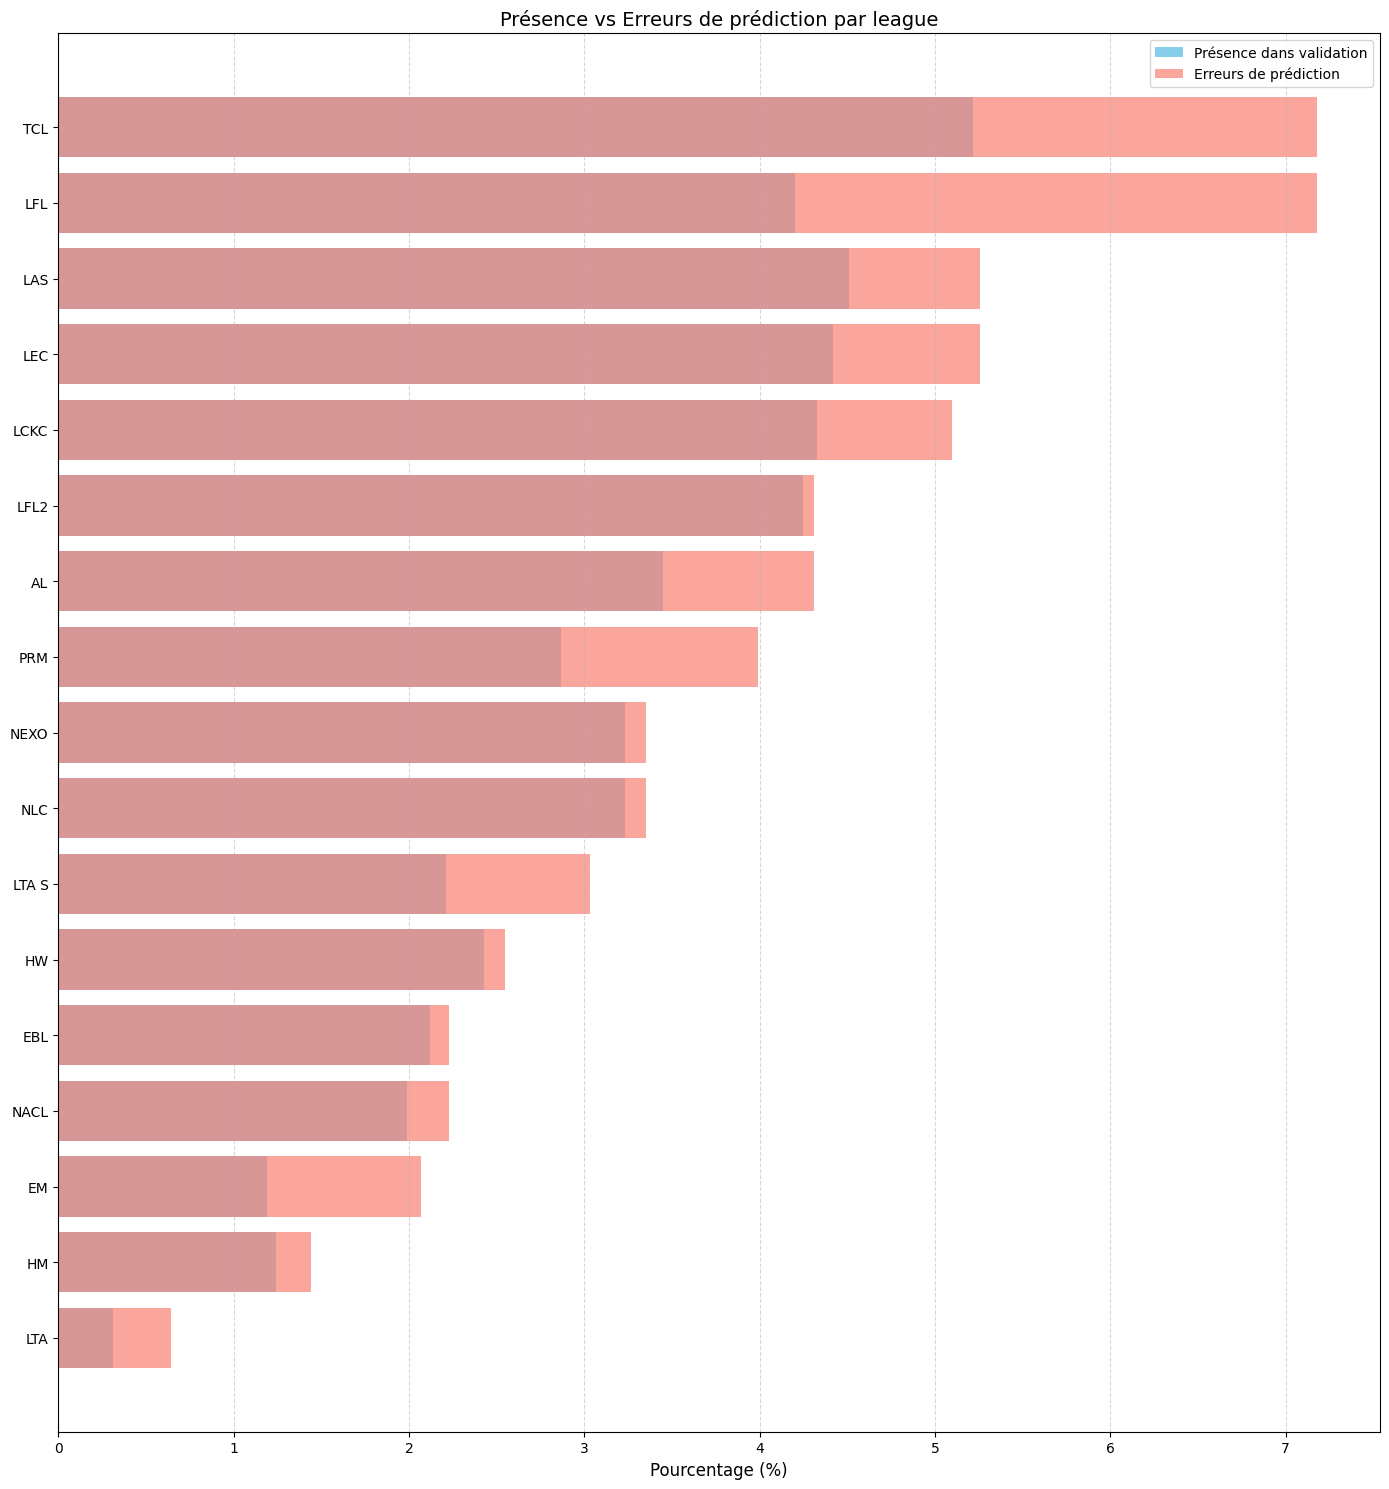

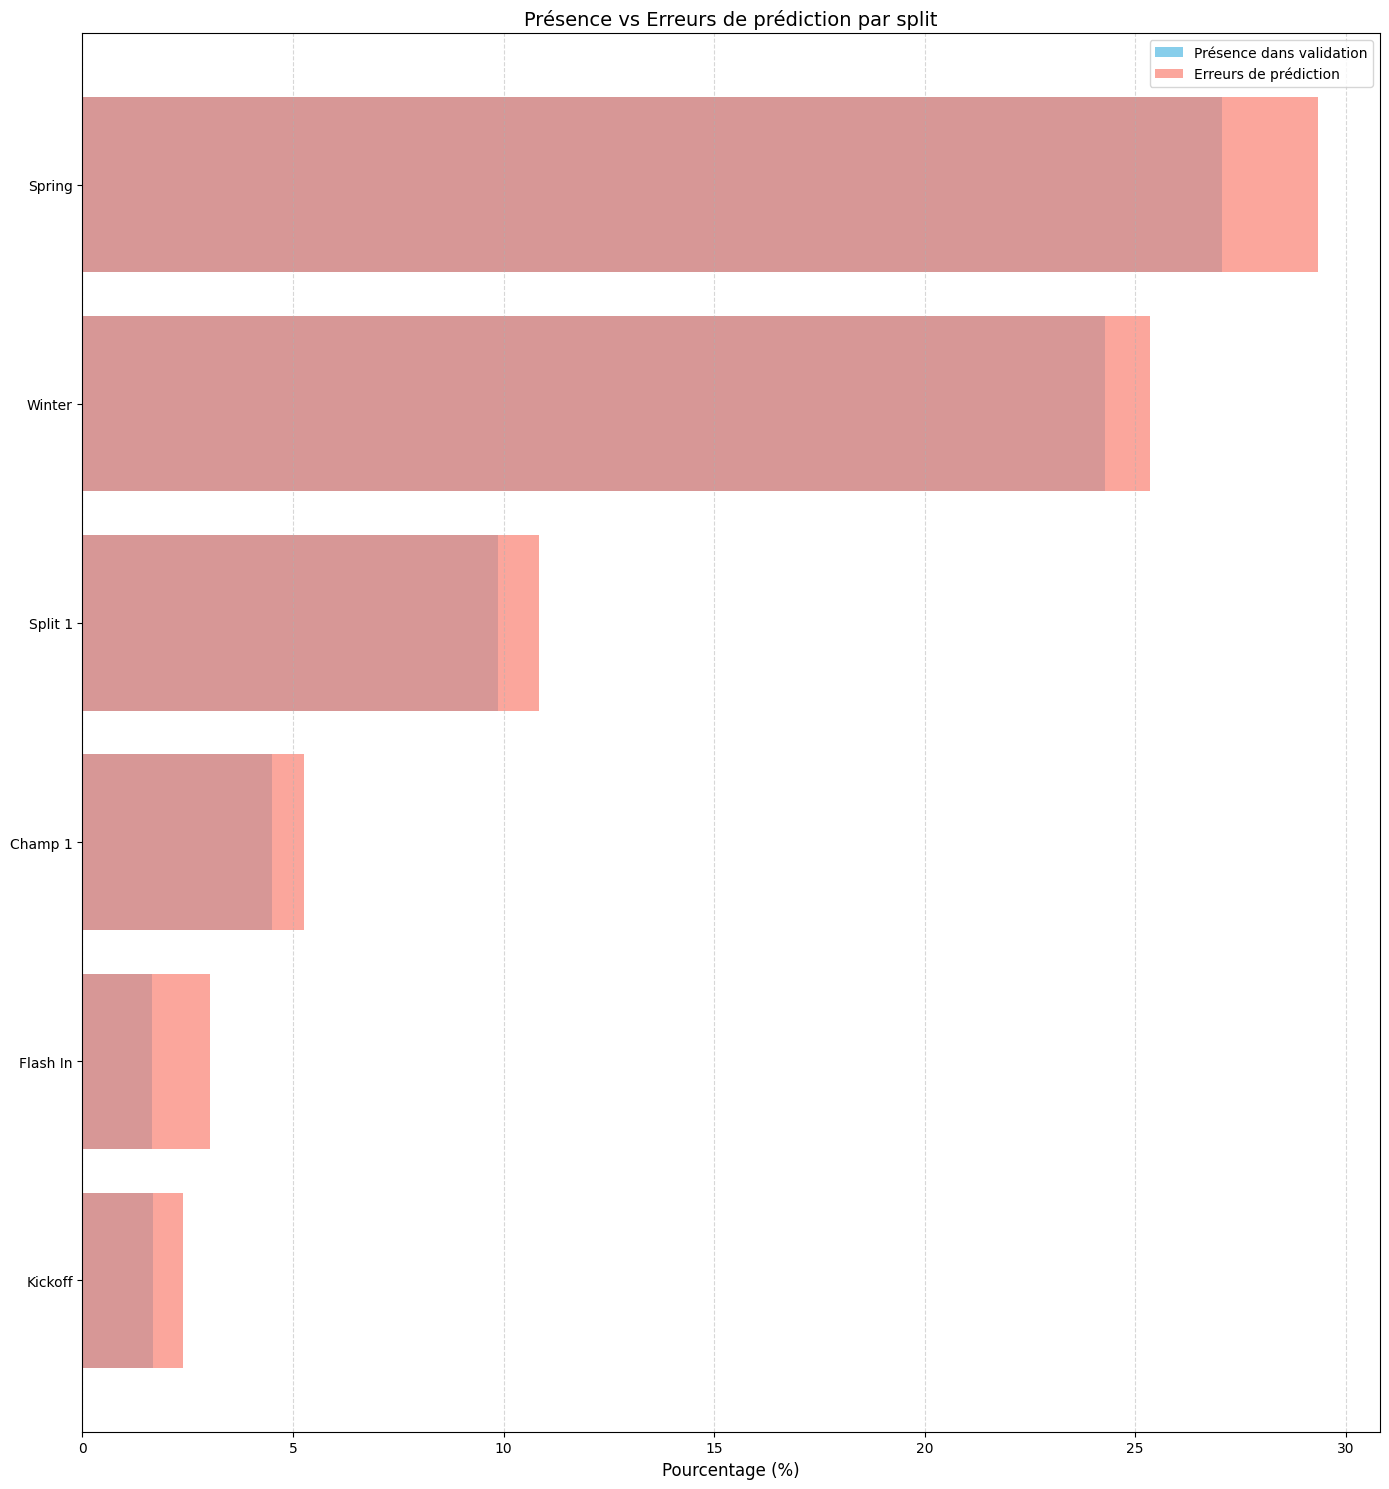

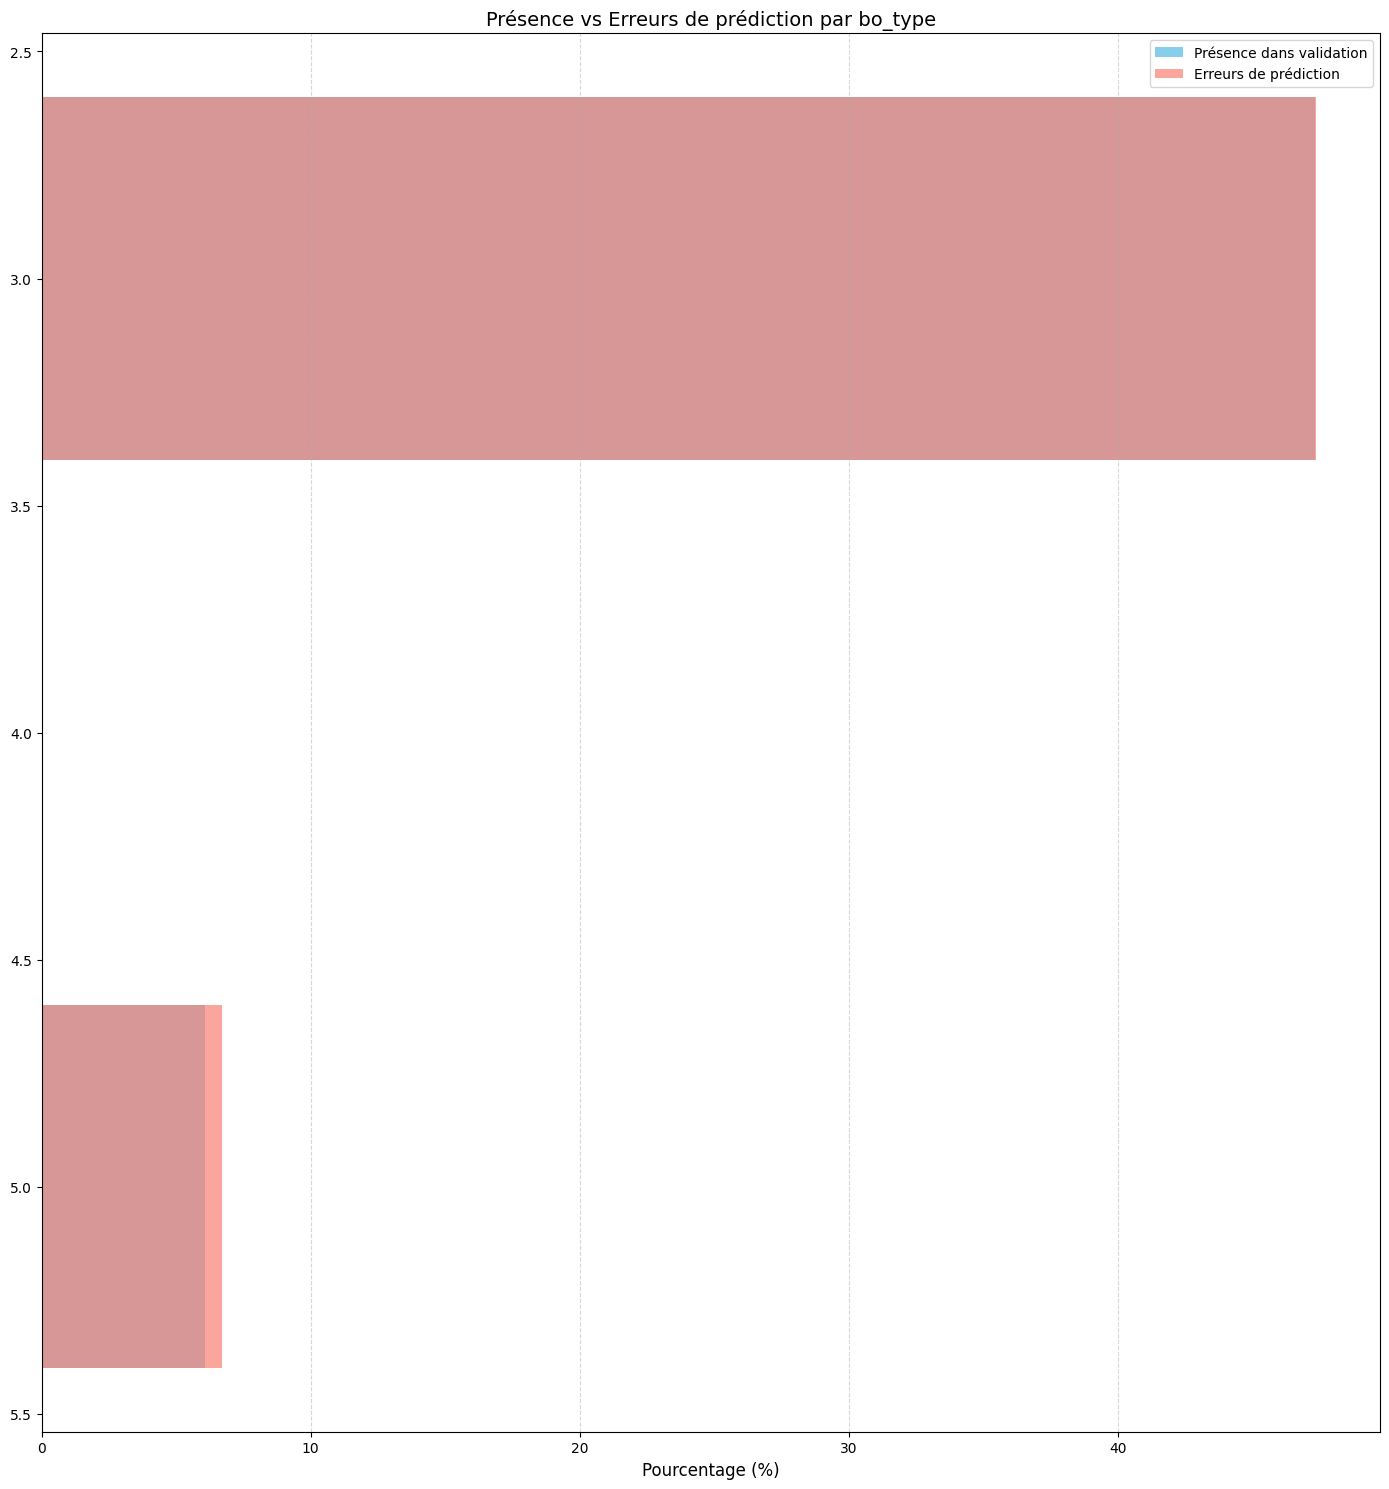

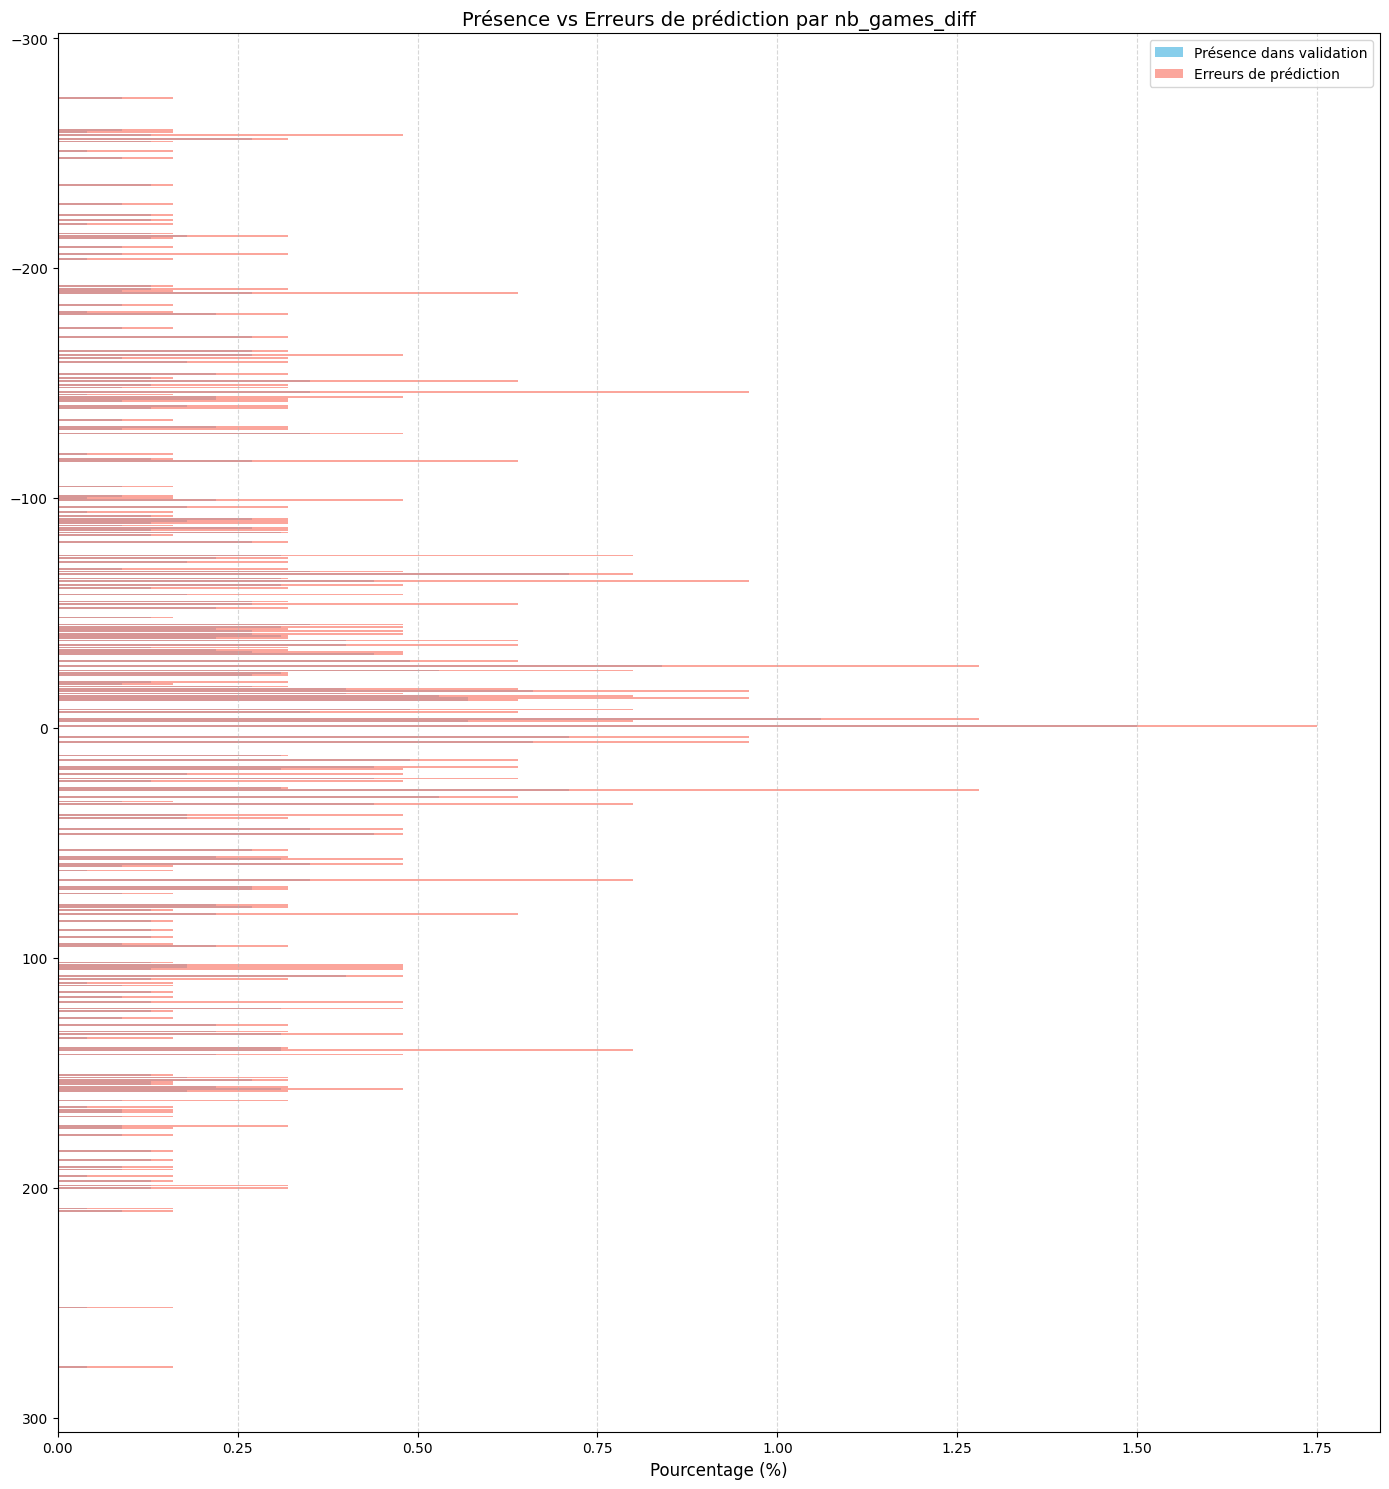

In [31]:
wrong_predictions = ~log_today.was_correct # 692 Rows True
X_wrong_bc_of_elo =  X_validation[
        (wrong_predictions) &
        (
            (X_validation.elo_diff > 0) & (X_validation.result == 1) |
            (X_validation.elo_diff < 0) & (X_validation.result == 0)
        )
    ]

print(f"Number of wrong predictions : {X_validation[wrong_predictions].shape[0]}" )
print(f"Number of wrong predictions because of elo : {X_wrong_bc_of_elo.shape[0]} which represents {X_wrong_bc_of_elo.shape[0]*100/X_validation[wrong_predictions].shape[0]:.2f}%" )
print(f"Mean elo diff above 0 for X_validation :{X_validation[X_validation.elo_diff >0].elo_diff.median()} and for wrong prediction : {X_wrong_bc_of_elo[X_wrong_bc_of_elo.elo_diff >0].elo_diff.median()}")
print(f"Mean elo diff under 0 for X_validation :{X_validation[X_validation.elo_diff <0].elo_diff.median()} and for wrong prediction : {X_wrong_bc_of_elo[X_wrong_bc_of_elo.elo_diff <0].elo_diff.median()}")

def compare_columns_wrong_predictions(column):
    df_compare = pd.concat([X_validation[column].value_counts()*100/X_validation.shape[0], X_wrong_bc_of_elo[column].value_counts()*100/X_wrong_bc_of_elo.shape[0]],axis=1)
    df_compare.columns = [f"% {column} in validation", f"% {column} in wrong predictions"]
    df_compare = df_compare.sort_values(f"% {column} in wrong predictions", ascending=False).round(2)
    df_compare = df_compare[df_compare[f"% {column} in wrong predictions"] > (df_compare[f"% {column} in validation"] )] # Take only the teams that are much more present in wrong predictions
    #display(df_compare)
    # Tracer un barplot
    # Faire un barplot double
    plt.figure(figsize=(14, 15))
    
    # Barres bleues pour la présence dans le dataset
    plt.barh(df_compare.index, df_compare[f"% {column} in validation"], color='skyblue', label='Présence dans validation')
    
    # Barres rouges transparentes par-dessus pour erreurs
    plt.barh(df_compare.index, df_compare[f"% {column} in wrong predictions"], color='salmon', alpha=0.7, label='Erreurs de prédiction')
    
    # Ajouter titres et légende
    plt.xlabel('Pourcentage (%)', fontsize=12)
    plt.title(f'Présence vs Erreurs de prédiction par {column}', fontsize=14)
    plt.legend()
    plt.gca().invert_yaxis()  # La ligue avec plus d'erreurs en haut
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()

for object_column in ["league","split", "bo_type", "nb_games_diff"]:
    compare_columns_wrong_predictions(object_column)

# 86


### Initial load of data TO DELETE


We see that the games with wrong predictions have an elo usually closer. It's thougher games 


From the graph, we can see that there isn't specially a league or split that is really more difficult to predict. Same for the league seasonnal and international.

However, we see that he have much more difficulties when it's a BO3. After adding a feature which is the win_rate for this type of BO we increased the accuracy of 0.41 !

Now we'll test the number of game of team implicted, and check others columns which were showing the contrary of elo. 

In [32]:
print(f"Median nb_games_diff above 0 for X_validation :{X_validation[X_validation.nb_games_diff >0].nb_games_diff.median()} and for wrong prediction : {X_wrong_bc_of_elo[X_wrong_bc_of_elo.nb_games_diff >0].nb_games_diff.median()}")
print(f"Median nb_games_diff under 0 for X_validation :{X_validation[X_validation.nb_games_diff <0].nb_games_diff.median()} and for wrong prediction : {X_wrong_bc_of_elo[X_wrong_bc_of_elo.nb_games_diff <0].nb_games_diff.median()}")
print(f"Median team new game for X_validation : {X_validation.new_games.sum()} and for wrong prediction : {X_wrong_bc_of_elo.new_games.sum()}")
column = "teamname"
print(X_validation.select_dtypes(include="object").columns.tolist())
df_compareA = pd.concat([X_validation["teamnameA"].value_counts()*100/X_validation.shape[0], X_wrong_bc_of_elo["teamnameA"].value_counts()*100/X_wrong_bc_of_elo.shape[0]],axis=1)
df_compareB = pd.concat([X_validation["teamnameB"].value_counts()*100/X_validation.shape[0], X_wrong_bc_of_elo["teamnameB"].value_counts()*100/X_wrong_bc_of_elo.shape[0]],axis=1)

df_compareA.columns = [f"% {column} in validation", f"% {column} in wrong predictions"]
df_compareB.columns = [f"% {column} in validation", f"% {column} in wrong predictions"]
df_compare = pd.concat([df_compareA/2, df_compareB/2]) 
df_compare = df_compare[df_compare[f"% {column} in wrong predictions"] > (df_compare[f"% {column} in validation"] + 0.2)] # Take only the teams that are much more present in wrong predictions
df_compare = df_compare.sort_values(f"% {column} in wrong predictions", ascending=False).round(2)
#display(df_compare)
teams_strongly_wrong = df_compare.index.unique()
#print("list of teams :", teams_strongly_wrong)

for team in teams_strongly_wrong:
    date_min = X_train[(X_train["teamnameA"] == team) | (X_train["teamnameB"] == team)].date.min()
    print(f"1st game of the team {team} : {date_min}")
    


#display(df_compare)
# Tracer un barplot
# Faire un barplot double
# plt.figure(figsize=(14, 15))

# # Barres bleues pour la présence dans le dataset
# plt.barh(df_compare.index, df_compare[f"% {column} in validation"], color='skyblue', label='Présence dans validation')

# # Barres rouges transparentes par-dessus pour erreurs
# plt.barh(df_compare.index, df_compare[f"% {column} in wrong predictions"], color='salmon', alpha=0.7, label='Erreurs de prédiction')

# # Ajouter titres et légende
# plt.xlabel('Pourcentage (%)', fontsize=12)
# plt.title(f'Présence vs Erreurs de prédiction par {column}', fontsize=14)
# plt.legend()
# plt.gca().invert_yaxis()  # La ligue avec plus d'erreurs en haut
# plt.grid(axis='x', linestyle='--', alpha=0.5)
# plt.tight_layout()

Median nb_games_diff above 0 for X_validation :52.0 and for wrong prediction : 58.0
Median nb_games_diff under 0 for X_validation :-60.0 and for wrong prediction : -61.5
Median team new game for X_validation : 108 and for wrong prediction : 14
['league', 'split', 'date', 'teamnameA', 'teamnameB']
1st game of the team Papara SuperMassive : 2020-02-01 10:28:29
1st game of the team BNK FEARX Youth : 2024-01-15 05:06:40
1st game of the team Ici Japon Corp. Esport : 2024-03-01 17:54:23
1st game of the team Galions : nan
1st game of the team ULF Esports : nan
1st game of the team BAAM Esports : nan
1st game of the team IziDream : nan
1st game of the team Solary : 2020-01-21 21:16:27
1st game of the team Bushido Wildcats : nan
1st game of the team Dplus KIA Youth : 2021-10-30 01:38:59
1st game of the team One More Esports : 2023-04-12 18:42:34
1st game of the team Zerance : 2024-03-01 20:45:39
1st game of the team West Point Esports : 2023-07-01 09:10:56
1st game of the team Karmine Corp Blue

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


1st game of the team FURIA : 2020-01-25 19:14:07
1st game of the team Team BDS : 2021-01-19 22:00:01
1st game of the team KaBuM! Ilha das Lendas : nan


We notice that half of the team are very recent 2024 or even 2025 and that's why their elo is not accurate.
Implementing elo_decay and including features with recent win_rate might helps

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: Ru

Nb wrongs predictions bc of elo 627
cols diff in the other way of the elo


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: Ru

,appearance
opp_inhibitors_diff,444
opp_towers_diff,421
deaths_diff,415
opp_dragons_diff,400
opp_barons_diff,390
...,...
dragons (type unknown)_diff,0
damageshare_diff,0
earnedgoldshare_diff,0
total cs_diff,0


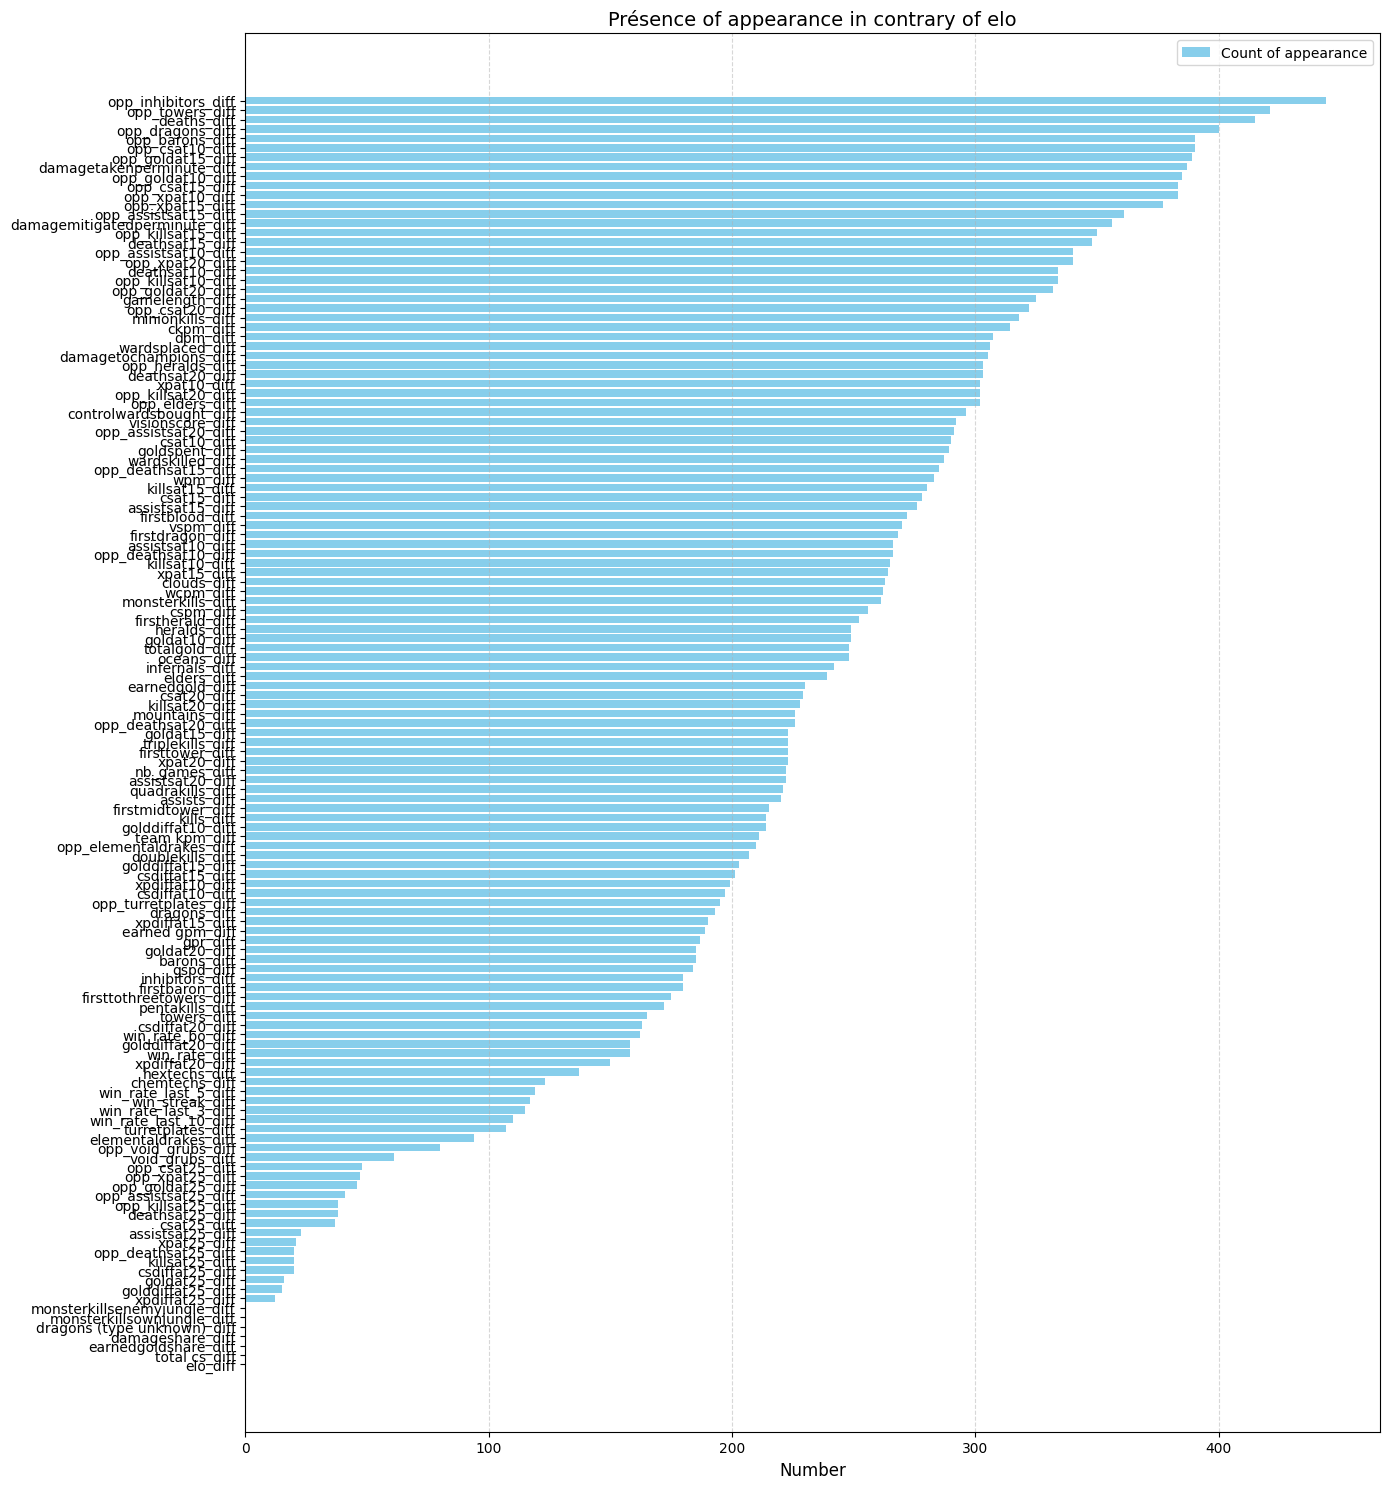

In [33]:
df_cols_contrary_elo = pd.DataFrame(columns=["appearance"])
cols_diff = [col for col in X_wrong_bc_of_elo.columns if col.endswith('_diff')]

for col in cols_diff:
    df_cols_contrary_elo.loc[col] = X_wrong_bc_of_elo[((X_wrong_bc_of_elo["elo_diff"] > 0) & (X_wrong_bc_of_elo[col] < 0)) | ((X_wrong_bc_of_elo["elo_diff"] < 0) & (X_wrong_bc_of_elo[col] > 0))].shape[0]

df_cols_contrary_elo = df_cols_contrary_elo.sort_values("appearance", ascending=False)
print(f"Nb wrongs predictions bc of elo {X_wrong_bc_of_elo.shape[0]}")
print("cols diff in the other way of the elo")
display(df_cols_contrary_elo)
plt.figure(figsize=(14, 15))

# Barres bleues pour la présence dans le dataset
plt.barh(df_cols_contrary_elo.index, df_cols_contrary_elo["appearance"], color='skyblue', label='Count of appearance')


# Ajouter titres et légende
plt.xlabel('Number', fontsize=12)
plt.title(f'Présence of appearance in contrary of elo', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()  # La ligue avec plus d'erreurs en haut
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()


In [34]:
["opp_inhibitors_diff","opp_towers_diff","opp_dragons_diff","opp_barons_diff","deaths_diff"]
# match_logs = pd.DataFrame(columns=columns_match_logs)
# match_logs.to_csv("match_logs.csv")
# raw_2025_empty = X_2025[0:0]
# raw_2025_empty.to_csv("raw_data_actual_season.csv")
# X_intuition.to_csv("X_train.csv")


['opp_inhibitors_diff',
 'opp_towers_diff',
 'opp_dragons_diff',
 'opp_barons_diff',
 'deaths_diff']

1. Increase accuracy
   - Elo decay
   - BF hyperparameters
   - new features, win_rate_play_offs
2. Accuracy by day
3. Get next games and predictions for next day
   - Finish the function that take in param the name of both teams
   - print proba

In [116]:
# Date de demain au format ISO
tomorrow = (datetime.utcnow() + timedelta(days=1)).strftime('%Y-%m-%d')
print(tomorrow)

# API endpoint de Leaguepedia (Liquipedia)
url = "https://lol.fandom.com/api.php"

# Paramètres de la requête Cargo pour interroger les matchs à partir de demain
params = {
    "action": "cargoquery",
    "format": "json",
    "tables": "MatchSchedule",
    "fields": "MatchSchedule.Team1,MatchSchedule.Team2,MatchSchedule.DateTime_UTC,MatchSchedule.OverviewPage,MatchSchedule.BestOf,MatchSchedule.Round",
    "where": f"MatchSchedule.DateTime_UTC >= '{tomorrow}'",
    "order_by": "MatchSchedule.DateTime_UTC ASC",
    "limit": "500"  # Augmente si nécessaire
}

# Requête HTTP
response = requests.get(url, params=params)

# Vérifier et afficher les résultats
if response.status_code == 200:
    results = response.json()["cargoquery"]
    # Étape 2 : Grouper les matchs par date (UTC, sans l'heure)
    match_data = [
        {
            "teamnameA": m["title"]["Team1"],
            "teamnameB": m["title"]["Team2"],
            "date": m["title"]["DateTime UTC"],
            "playoffs": 0 if m["title"]["Round"] is None else 1,
            "bo_type": m["title"]["BestOf"],
            "league": m["title"]["OverviewPage"].split("/")[0]
        }
        for m in results
    ]
    df = pd.DataFrame(match_data)
    df["date"] = pd.to_datetime(df["date"]).dt.date
    
    # Étape 3 : Trouver la date de la prochaine journée (la première date du DataFrame)
    if not df.empty:
        next_match_day = df["date"].min()
        df_next_day = df[df["date"] == next_match_day]
        #display(df_next_day)
    else:
        print("Aucun match trouvé à partir d'aujourd'hui.")
else:
    print("Erreur de requête :", response.status_code)


def create_feature_row(row):
    for col in col_best_perf:
        if (col.endswith("_diff")):
            if (col.startswith("win_rate_last_")):
                window = int(col.split("_")[3])
                row[col] = np.mean(dict_stats.get(row.teamnameA).get("result")[-window:]) - np.mean(dict_stats.get(row.teamnameB).get("result")[-window:])
            elif (col == "win_rate_diff"):
                row[col] = np.mean(dict_stats.get(row.teamnameA).get("result")) - np.mean(dict_stats.get(row.teamnameB).get("result"))
            elif (col == "win_rate_bo_diff"):
                win_rate_bo_A = np.mean(dict_stats[row.teamnameA][f"bo_{row['bo_type']}"]) if len(dict_stats[row.teamnameA][f"bo_{row['bo_type']}"]) >= 1 else np.mean(dict_stats.get(row.teamnameA).get("result"))
                win_rate_bo_B = np.mean(dict_stats[row.teamnameB][f"bo_{row['bo_type']}"]) if len(dict_stats[row.teamnameB][f"bo_{row['bo_type']}"]) >= 1 else np.mean(dict_stats.get(row.teamnameB).get("result"))
                row[col] = win_rate_bo_A - win_rate_bo_B
            elif (col == "nb_games_diff"):
                row[col] = len(dict_stats.get(row.teamnameA).get("result")) - len(dict_stats.get(row.teamnameB).get("result"))
            elif (col == "win_streak_diff"):
                row[col] = dict_stats.get(row.teamnameA).get("win_streak")[-1] - dict_stats.get(row.teamnameB).get("win_streak")[-1]
            else:
                row[col] = np.mean(dict_stats.get(row.teamnameA).get(col[:-5])) - np.mean(dict_stats.get(row.teamnameB).get(col[:-5]))
        elif (col == "h2h_win_rate_AvsB"):
            if (row.teamnameA < row.teamnameB):
                h2h_key = row.teamnameA + row.teamnameB
                h2h_win_rate_AvsB = np.mean(dict_stats[h2h_key]) if dict_stats.get(h2h_key) else 0.5
            else:
                h2h_key = row.teamnameB + row.teamnameA 
                h2h_win_rate_AvsB = (1 - np.mean(dict_stats[h2h_key])) if dict_stats.get(h2h_key) else 0.5
            row["h2h_win_rate_AvsB"] = h2h_win_rate_AvsB
    return row

display(df_next_day)
df_next_day = df_next_day[df_next_day.teamnameA.isin(dict_stats) & (df_next_day.teamnameB.isin(dict_stats)) ]
df_next_day = df_next_day.apply(create_feature_row, axis=1).reset_index()
display(df_next_day)



2025-05-12
{'title': {'Team1': 'Somos Blink', 'Team2': 'Black WAP', 'DateTime UTC': '2025-05-12 01:00:00', 'OverviewPage': 'Female Super League/2025 Season/Split 1', 'BestOf': '3', 'Round': None, 'DateTime UTC__precision': '0'}}


,teamnameA,teamnameB,date,playoffs,bo_type,league
0,Somos Blink,Black WAP,2025-05-12,0,3,Female Super League
1,KT Rolster Challengers,DN Freecs Challengers,2025-05-12,0,3,LCK CL
2,Anyone's Legend.Young,Royal Club,2025-05-12,0,3,LDL
3,Oh My God Academy,LNG Academy,2025-05-12,0,3,LDL
4,Dplus KIA Challengers,BNK FEARX Youth,2025-05-12,0,3,LCK CL
5,LGD Gaming Young Team,Team WE Academy,2025-05-12,0,3,LDL
6,Bilibili Gaming Junior,Weibo Gaming Youth Team,2025-05-12,0,3,LDL
7,wangting,CTBC Flying Oyster Academy,2025-05-12,0,3,PCS
8,Gen.G Global Academy,T1 Esports Academy,2025-05-12,0,3,LCK CL
9,ThunderTalk Gaming,Anyone's Legend,2025-05-12,0,3,LPL


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,index,teamnameA,teamnameB,date,playoffs,bo_type,league,monsterkillsownjungle_diff,opp_xpat15_diff,opp_deathsat25_diff,...,team kpm_diff,ckpm_diff,controlwardsbought_diff,totalgold_diff,damagetakenperminute_diff,gamelength_diff,wcpm_diff,win_rate_bo_diff,nb_games_diff,win_streak_diff
0,1,KT Rolster Challengers,DN Freecs Challengers,2025-05-12,0,3,LCK CL,NaN,-180.520752,NaN,...,0.089870,0.001932,5.007891,1867.934867,-135.316663,6.523448,0.084656,0.390805,12,4
1,3,Oh My God Academy,LNG Academy,2025-05-12,0,3,LDL,NaN,-344.979150,NaN,...,0.022480,0.013528,1.200740,1385.149979,48.127206,78.246288,0.204477,0.000409,-5,-4
2,4,Dplus KIA Challengers,BNK FEARX Youth,2025-05-12,0,3,LCK CL,NaN,-56.104004,NaN,...,-0.049175,-0.145570,4.647136,-615.793062,-801.348990,-12.777278,0.045450,0.099459,157,-1
3,5,LGD Gaming Young Team,Team WE Academy,2025-05-12,0,3,LDL,-8.810170,470.931492,-1.166254,...,-0.091256,-0.016961,0.079547,-3664.497141,-78.235668,-39.394924,-0.061258,-0.283654,5,0
4,6,Bilibili Gaming Junior,Weibo Gaming Youth Team,2025-05-12,0,3,LDL,NaN,1855.043222,NaN,...,-0.186172,-0.120552,2.910506,2345.216048,135.994300,110.095678,-0.083317,-0.176101,51,-2
5,7,wangting,CTBC Flying Oyster Academy,2025-05-12,0,3,PCS,NaN,-30.583324,NaN,...,0.319524,0.282134,-2.561901,1910.516660,-21.623909,-45.044039,0.078479,0.120879,-4,-1
6,8,Gen.G Global Academy,T1 Esports Academy,2025-05-12,0,3,LCK CL,NaN,213.857459,NaN,...,-0.038009,-0.001592,0.119656,-331.773835,78.381815,21.502546,-0.003781,-0.159387,-3,-1
7,10,Top Esports Challenger,ThunderTalk Gaming Young,2025-05-12,0,3,LDL,-15.432439,243.015608,-1.438722,...,-0.099195,-0.053841,3.519936,-4051.374104,-78.663031,-37.193539,-0.098112,-0.146739,27,1
8,11,Ground Zero Gaming,TALON Academy,2025-05-12,0,3,PCS,NaN,315.785879,NaN,...,-0.104096,-0.043433,-3.961477,-2717.908060,-35.086197,-44.615250,-0.031018,-0.088889,38,-2
9,13,Oxygen Gaming,Universae Instituto FP,2025-05-12,0,1,Liga Nexo,NaN,394.117752,NaN,...,-0.016584,-0.057456,4.534056,7679.850726,95.018025,233.116307,0.106591,0.086486,-26,2


# Predictions for the next day

In [117]:
y_predict_next_day = pipeline_LGB_best_perf.predict(df_next_day)
y_proba_next_day = pipeline_LGB_best_perf.predict_proba(df_next_day)[:,1] # B Win
df_next_day["prediction"] = y_predict_next_day
df_next_day["prediction_proba"] = y_proba_next_day

for i, row in df_next_day.iterrows():
    print(f"h2h: {row.h2h_win_rate_AvsB}, {row.teamnameA} VS {row.teamnameB} : {row.teamnameA if y_predict_next_day[i] == 0 else row.teamnameB} with {y_proba_next_day[i] if y_proba_next_day[i] >= 0.5 else (1-y_proba_next_day[i]):.2%}")

df_next_day.to_csv("df_next_day.csv")

h2h: 0.7857142857142857, KT Rolster Challengers VS DN Freecs Challengers : KT Rolster Challengers with 76.99%
h2h: 0.5, Oh My God Academy VS LNG Academy : Oh My God Academy with 53.23%
h2h: 0.4, Dplus KIA Challengers VS BNK FEARX Youth : Dplus KIA Challengers with 56.67%
h2h: 0.5, LGD Gaming Young Team VS Team WE Academy : Team WE Academy with 69.28%
h2h: 0.5, Bilibili Gaming Junior VS Weibo Gaming Youth Team : Weibo Gaming Youth Team with 60.68%
h2h: 1.0, wangting VS CTBC Flying Oyster Academy : CTBC Flying Oyster Academy with 51.93%
h2h: 0.3076923076923077, Gen.G Global Academy VS T1 Esports Academy : T1 Esports Academy with 62.03%
h2h: 0.5, Top Esports Challenger VS ThunderTalk Gaming Young : ThunderTalk Gaming Young with 53.57%
h2h: 0.0, Ground Zero Gaming VS TALON Academy : TALON Academy with 54.13%
h2h: 0.5, Oxygen Gaming VS Universae Instituto FP : Oxygen Gaming with 57.04%
h2h: 0.5, G2 Hel VS Kawaii Kiwis : Kawaii Kiwis with 66.79%
h2h: 0.5, ERKO Esports VS OGC Esports : ERKO E

## Adding match of the next day in the database

In [120]:
cols_lol_predict = ["date","teamnameA","teamnameB"] # Cols needed for the website lol_predict but not for the model
#display(df_supabase_next_day.head())

df_supabase_next_day = df_next_day.rename(columns={
    "index":"bo_id",
    "teamnameA": "teamname_a",
    "teamnameB": "teamname_b",
})
# Replace such that all invalid values (NaN, inf) become Python native None (optional)
df_supabase_next_day = df_supabase_next_day.replace([np.nan, np.inf, -np.inf], None)
df_supabase_next_day.bo_id = df_supabase_next_day.apply(lambda x : f"{x.date}-{x.teamname_a}-{x.teamname_b}", axis=1)
df_supabase_next_day.date = df_supabase_next_day.date.astype("string")
# Now convert to list of dicts while skipping None values per row
data_to_insert_next_day = [
    {k: v for k, v in row.items() if v is not None}
    for row in df_supabase_next_day.to_dict(orient="records")
]
#display(df_supabase_next_day)
#print(data_to_insert_next_day[0])

# Perform batch insert
response = supabase.table("matches").upsert(data_to_insert_next_day).execute()

# Initial test 
Validated on 2025 : Mean patch better, stratify=y better, game_length_diff useless
Google Correlation : 
### Very low :
- xpat25b 0
- golddiffat25b 0
- csat25B 0
- firstdragonA 0
- firstbloodA 0
- damageshareA 0 (only 2 value ??)
- earnedgoldshareA 0 (only 2 value ??)
- - totalcs 0 (only 2 value ??)
- bo_type 0.001 (feature engineer win rate bo type ?)
- playsoffs 0 (feature engineer win rate by playoffs ?)
- year -



Columns : ['playoffsA', 'patchA', 'gamelengthA', 'killsA', 'deathsA', 'assistsA', 'doublekillsA', 'triplekillsA', 'quadrakillsA', 'pentakillsA', 'firstbloodA', 'team kpmA', 'ckpmA', 'firstdragonA', 'dragonsA', 'opp_dragonsA', 'elementaldrakesA', 'opp_elementaldrakesA', 'infernalsA', 'mountainsA', 'cloudsA', 'oceansA', 'chemtechsA', 'hextechsA', 'eldersA', 'opp_eldersA', 'firstheraldA', 'heraldsA', 'opp_heraldsA', 'void_grubsA', 'opp_void_grubsA', 'firstbaronA', 'baronsA', 'opp_baronsA', 'firsttowerA', 'towersA', 'opp_towersA', 'firstmidtowerA', 'firsttothreetowersA', 'turretplatesA', 'opp_turretplatesA', 'inhibitorsA', 'opp_inhibitorsA', 'damagetochampionsA', 'dpmA', 'damagetakenperminuteA', 'damagemitigatedperminuteA', 'wardsplacedA', 'wpmA', 'wardskilledA', 'wcpmA', 'controlwardsboughtA', 'visionscoreA', 'vspmA', 'totalgoldA', 'earnedgoldA', 'earned gpmA', 'goldspentA', 'gspdA', 'gprA', 'minionkillsA', 'monsterkillsA', 'cspmA', 'goldat10A', 'xpat10A', 'csat10A', 'opp_goldat10A', 'opp_xpat10A', 'opp_csat10A', 'golddiffat10A', 'xpdiffat10A', 'csdiffat10A', 'killsat10A', 'assistsat10A', 'deathsat10A', 'opp_killsat10A', 'opp_assistsat10A', 'opp_deathsat10A', 'goldat15A', 'xpat15A', 'csat15A', 'opp_goldat15A', 'opp_xpat15A', 'opp_csat15A', 'golddiffat15A', 'xpdiffat15A', 'csdiffat15A', 'killsat15A', 'assistsat15A', 'deathsat15A', 'opp_killsat15A', 'opp_assistsat15A', 'opp_deathsat15A', 'from_playoffs-opp_deathsat15_with_B', 'teamnameA', 'teamnameB', 'bo_type', 'result', 'team_A_elo', 'team_B_elo', 'team_A_win_rate', 'team_B_win_rate']
## Random Forest
19 Rows of EM League : 
- Cross-validation Accuracy: 0.333
- Test Accuracy: 0.25

955 rows × 192 of 2025 : 
- Cross-validation Accuracy: 0.6165
- Best Parameters: {'model__max_depth': None, 'model__min_samples_split': 10, 'model__n_estimators': 50}
- Test Accuracy: 0.6702

# (without unknown team)
863 rows × 196 columns of 2025  with nb_games:
- Cross-validation Accuracy: 0.6043
- Best Parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
- Test Accuracy: 0.6127


- Cross-validation Accuracy without nb_games: 0.6145
- Best Parameters: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 50}
- Test Accuracy: 0.6301



Dropping team name : 
- Cross-validation Accuracy: 0.6348
- Cross-validation Accuracy XGB: 0.6014

Increasing to 2024-2025 :
- Cross-validation Accuracy Random: 0.6575
- Cross-validation Accuracy XGB (128): 0.6582

K-multiplier 45 :
- Cross-validation Accuracy Random: 0.6613
- Cross-validation Accuracy XGB: 0.6593